# Detrend and Estimate Noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy.polynomial.polynomial as poly
import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
from   scipy import ndimage
from   scipy.interpolate import UnivariateSpline
from   scipy.interpolate import interp1d
import astropy
from   astropy.io import fits as pyfits
from   astropy.timeseries import LombScargle
from   sklearn.cluster import KMeans

import csv
import sys
import os
import glob
import warnings
import argparse
import json
import importlib as imp
from   copy import deepcopy
from   timeit import default_timer as timer

import lightkurve as lk
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as exo
import aesara_theano_fallback.tensor as T
from   aesara_theano_fallback import aesara as theano
from   celerite2.theano import GaussianProcess
from   celerite2.theano import terms as GPterms

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# Manually set I/O parameters
#### User should manually set MISSION, TARGET, PRIMARY_DIR,  and CSV_FILE
#### Note that if using DR25, you will need to manually correct epochs from BJD to BJKD with an offset of 2454833.0 days; the cumulative exoplanet archive catalog has already converted epochs to BJKD

In [2]:
# select mission, target, and paths
MISSION = "Kepler"
TARGET  = "K00137"
PRIMARY_DIR  = '/Users/research/projects/alderaan/'

if MISSION == "Kepler":
    CSV_FILE = PRIMARY_DIR + "Catalogs/cumulative_koi_catalog.csv"
    
if MISSION == "Simulated":
    CSV_FILE = PRIMARY_DIR + "Catalogs/simulated_catalog_eccentric.csv"

In [3]:
# here's where we parse the inputs
try:
    parser = argparse.ArgumentParser(description="Inputs for ALDERAAN transit fiting pipeline")
    parser.add_argument("--mission", default=None, type=str, required=True, \
                        help="Mission name")
    parser.add_argument("--target", default=None, type=str, required=True, \
                        help="Target name; see ALDERAAN documentation for acceptable formats")
    parser.add_argument("--primary_dir", default=None, type=str, required=True, \
                        help="Primary directory path for accessing lightcurve data and saving outputs")
    parser.add_argument("--csv_file", default=None, type=str, required=True, \
                        help="Path to .csv file containing input planetary parameters")


    args = parser.parse_args()
    MISSION      = args.mission
    TARGET       = args.target
    PRIMARY_DIR  = args.primary_dir
    CSV_FILE     = args.csv_file    
    
except:
    pass

usage: ipykernel_launcher.py [-h] --mission MISSION --target TARGET
                             --primary_dir PRIMARY_DIR --csv_file CSV_FILE
ipykernel_launcher.py: error: the following arguments are required: --mission, --target, --primary_dir, --csv_file


# Make sure the necessary paths exist

In [4]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'


# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Read in planet and stellar parameters

In [5]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
if MISSION == 'Kepler':
    KOI_ID = TARGET
    
elif MISSION == 'Simulated':
    KOI_ID = "K" + TARGET[1:]

else:
    raise ValueError("MISSION must be 'Kepler' or 'Simulated'")
    
    
# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['koi_id']) == KOI_ID

KIC = np.array(target_dict['kic_id'], dtype='int')[use]
NPL = np.array(target_dict['npl'], dtype='int')[use]

RSTAR = np.array(target_dict['rstar'],  dtype='float')[use]
LOGRHO = np.array(target_dict['logrho'],  dtype='float')[use]
LOGRHO_ERR1 = np.array(target_dict['logrho_err1'],  dtype='float')[use]
LOGRHO_ERR2 = np.array(target_dict['logrho_err2'],  dtype='float')[use]

U1 = np.array(target_dict['limbdark_1'], dtype='float')[use]
U2 = np.array(target_dict['limbdark_2'], dtype='float')[use]

PERIODS = np.array(target_dict['period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6          # [ppm] --> []
DURS    = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]
IMPACTS = np.array(target_dict['impact'], dtype='float')[use]

Reading in data from csv file


In [6]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(r == LOGRHO[0] for r in LOGRHO): LOGRHO = LOGRHO[0]
else: raise ValueError('There are inconsistencies with LOGRHO in the csv input file')

if all(r == LOGRHO_ERR1[0] for r in LOGRHO_ERR1): LOGRHO_ERR1 = LOGRHO_ERR1[0]
else: raise ValueError('There are inconsistencies with LOGRHO_ERR1 in the csv input file')

if all(r == LOGRHO_ERR2[0] for r in LOGRHO_ERR2): LOGRHO_ERR2 = LOGRHO_ERR2[0]
else: raise ValueError('There are inconsistencies with LOGRHO_ERR2 in the csv input file')

if all(u == U1[0] for u in U1): U1 = U1[0]
else: raise ValueError('There are inconsistencies with U1 in the csv input file')

if all(u == U2[0] for u in U2): U2 = U2[0]
else: raise ValueError('There are inconsistencies with U2 in the csv input file')

In [7]:
# limb darkening coefficients
UCOEFFS = [U1, U2]

# stellar density
RHO = 10**(LOGRHO)
RHO_ERR1 = 10**(LOGRHO+LOGRHO_ERR1) - RHO
RHO_ERR2 = 10**(LOGRHO+LOGRHO_ERR2) - RHO
RHO_ERR = np.sqrt(RHO_ERR1**2 + RHO_ERR2**2)/np.sqrt(2)

LOGRHO_ERR = np.sqrt(LOGRHO_ERR1**2 + LOGRHO_ERR2**2)/np.sqrt(2)

# Read in pre-downloaded lightcurve data
#### Kepler data can be retrieved by running the script "download_from_MAST.py"
#### Simulated data can be produced by running the script "simulate_lightcurve.py"

In [8]:
# short cadence
try:
    if MISSION == 'Kepler':
        sc_path  = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_sc*/')[0]
        sc_files = glob.glob(sc_path + '*')

        sc_rawdata_list = []
        for i, scf in enumerate(sc_files):
            sc_rawdata_list.append(lk.read(sc_files[i]))

        sc_raw_collection = lk.LightCurveCollection(sc_rawdata_list)
        sc_data = detrend.cleanup_lkfc(sc_raw_collection, KIC)


    elif MISSION == 'Simulated':
        sc_path = DOWNLOAD_DIR + 'Lightcurves/Kepler/simkplr' + '{0:09d}'.format(KIC) + '_sc/'
        sc_files = glob.glob(sc_path + '*')

        sc_rawdata_list = []
        for i, scf in enumerate(sc_files):
            sc_rawdata_list.append(io.load_sim_fits(scf))

        quarters = []
        for i, scrd in enumerate(sc_rawdata_list):
            quarters.append(scrd.quarter)

        order = np.argsort(quarters)
        sc_rawdata_list = [sc_rawdata_list[j] for j in order]

        sc_raw_collection = lk.LightCurveCollection(sc_rawdata_list)
        sc_data = detrend.cleanup_lkfc(sc_raw_collection)


except:
    sc_data = lk.LightCurveCollection([])

    
sc_quarters = []
for i, scd in enumerate(sc_data):
    sc_quarters.append(scd.quarter)

In [9]:
# long cadence
try:
    if MISSION == 'Kepler':
        lc_path  = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_lc*/')[0]
        lc_files = glob.glob(lc_path + '*')

        lc_rawdata_list = []
        for i, lcf in enumerate(lc_files):
            lkread = lk.read(lc_files[i])

            if ~np.isin(lkread.quarter, sc_quarters):
                lc_rawdata_list.append(lkread)

        lc_raw_collection = lk.LightCurveCollection(lc_rawdata_list)
        lc_data = detrend.cleanup_lkfc(lc_raw_collection, KIC)


    elif MISSION == 'Simulated':
        lc_path = DOWNLOAD_DIR + 'Lightcurves/Kepler/simkplr' + '{0:09d}'.format(KIC) + '_lc/'
        lc_files = glob.glob(lc_path + '*')

        lc_rawdata_list = []
        for i, lcf in enumerate(lc_files):
            lc_rawdata_list.append(io.load_sim_fits(lcf))


        quarters = []
        for i, lcrd in enumerate(lc_rawdata_list):
            quarters.append(lcrd.quarter)

        order = np.argsort(quarters)
        lc_rawdata_list = [lc_rawdata_list[j] for j in order]

        lc_raw_collection = lk.LightCurveCollection(lc_rawdata_list)
        lc_data = detrend.cleanup_lkfc(lc_raw_collection, KIC)


except:
    lc_data = LightCurveCollection([])

    
lc_quarters = []
for i, lcd in enumerate(lc_data):
    lc_quarters.append(lcd.quarter)

# Convert lk.LightCurve to LiteCurve

In [10]:
def LightKurve_to_LiteCurve(lklc):
    return LiteCurve(time  = np.array(lklc.time.value, dtype="float"),
                     flux  = np.array(lklc.flux.value, dtype="float"),
                     error = np.array(lklc.flux_err.value, dtype="float"),
                     cadno = np.array(lklc.cadenceno.value, dtype="int"),
                     quarter = lklc.quarter*np.ones(len(lklc.time), dtype="int"),
                     season  = (lklc.quarter%4)*np.ones(len(lklc.time), dtype="int"),
                     channel = lklc.channel*np.ones(len(lklc.time), dtype="int"),
                     quality = lklc.quality.value
                    )

In [11]:
sc_lite = []
lc_lite = []

for i, scd in enumerate(sc_data):
    sc_lite.append(LightKurve_to_LiteCurve(scd))
    
for i, lcd in enumerate(lc_data):
    lc_lite.append(LightKurve_to_LiteCurve(lcd))
    
    
# renaming here is an artifact of updates to my pipeline and dependencies
# this is easier than going through and fixing all variable names
sc_data = sc_lite
lc_data = lc_lite

# Determine time baseline

In [12]:
time_min = []
time_max = []

for i, scd in enumerate(sc_data):
    time_min.append(scd.time.min())
    time_max.append(scd.time.max())

for i, lcd in enumerate(lc_data):
    time_min.append(lcd.time.min())
    time_max.append(lcd.time.max())

TIME_START = np.min(time_min)
TIME_END   = np.max(time_max)

if TIME_START < 0:
    raise ValueError("START TIME [BKJD] is negative...this will cause problems")


# put epochs in range (TIME_START, TIME_START + PERIOD)
for npl in range(NPL):
    if EPOCHS[npl] < TIME_START:
        adj = 1 + (TIME_START - EPOCHS[npl])//PERIODS[npl]
        EPOCHS[npl] += adj*PERIODS[npl]        
        
    if EPOCHS[npl] > (TIME_START + PERIODS[npl]):
        adj = (EPOCHS[npl] - TIME_START)//PERIODS[npl]
        EPOCHS[npl] -= adj*PERIODS[npl]

# Initialize Planet objects

In [13]:
print('Initializing %d Planet objects' %NPL)

Initializing 3 Planet objects


In [14]:
planets = []
for npl in range(NPL):
    p = Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.depth    = DEPTHS[npl]
    p.duration = DURS[npl]
    p.impact   = IMPACTS[npl]
    
    if p.impact > 1 - np.sqrt(p.depth):
        p.impact = (1 - np.sqrt(p.depth))**2
        
    # estimate transit times from linear ephemeris
    p.tts = np.arange(p.epoch, TIME_END, p.period)

    # make transit indexes
    p.index = np.array(np.round((p.tts-p.epoch)/p.period),dtype='int')
    
    # add to list
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

# Read in Holczer+ 2016 TTVs

In [15]:
print("Building initial TTV model")

Building initial TTV model


In [16]:
HOLCZER_FILE = PRIMARY_DIR + "Catalogs/holczer_2016_kepler_ttvs.txt"

if MISSION == "Kepler":
    holczer_data = np.loadtxt(HOLCZER_FILE, usecols=[0,1,2,3])

    holczer_inds = []
    holczer_tts  = []
    holczer_pers = []

    for npl in range(NPL):
        koi = int(TARGET[1:]) + 0.01*(1+npl)
        use = np.isclose(holczer_data[:,0], koi, rtol=1e-10, atol=1e-10)
        
        # Holczer uses BJD -24548900; BJKD = BJD - 2454833
        if np.sum(use) > 0:
            holczer_inds.append(np.array(holczer_data[use,1], dtype="int"))
            holczer_tts.append(holczer_data[use,2] + holczer_data[use,3]/24/60 + 67)
            holczer_pers.append(np.median(holczer_tts[npl][1:] - holczer_tts[npl][:-1]))
            
        else:
            holczer_inds.append(None)
            holczer_tts.append(None)
            holczer_pers.append(np.nan)
            
    holczer_pers = np.asarray(holczer_pers)

# For simulated data, initilize with true TTVs + noise
#### Synthetic "Holczer" TTVs are approximated as ground truth + Student-t2 noise

In [17]:
if MISSION == "Simulated":
    holczer_inds = []
    holczer_tts  = []
    holczer_pers = []
    
    for npl, p in enumerate(planets):
        # read in the "ground truth" TTVs
        fname_in = DOWNLOAD_DIR + "TTVs/" + TARGET + "_0{0}_sim_ttvs.txt".format(npl)
        data_in  = np.loadtxt(fname_in).swapaxes(0,1)
    
        inds = np.array(data_in[0], dtype="int")
        tts_true  = np.array(data_in[1], dtype="float")
        
        # add some noise and reject transits without photometry cover
        if len(tts_true) > 20:
            tts_noisy = tts_true + stats.t.rvs(df=2, size=len(tts_true))*p.duration/3
        else:
            tts_noisy = tts_true + np.random.normal(size=len(tts_true))*p.duration/3
        
        keep = np.zeros(len(tts_noisy), dtype="bool")
        
        for i, t0 in enumerate(tts_noisy):
            for j, scd in enumerate(sc_data):
                if np.min(np.abs(scd.time - t0)) < p.duration:
                    keep[i] = True
            for j, lcd in enumerate(lc_data):
                if np.min(np.abs(lcd.time - t0)) < p.duration:
                    keep[i] = True
        
        holczer_inds.append(inds[keep])
        holczer_tts.append(tts_noisy[keep])
        holczer_pers.append(p.period)
        
        
    holczer_pers = np.array(holczer_pers)

# Smooth and interpolate Holczer TTVs where they exist

optimizing logp for variables: [logjit, mean, log_rho_off, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: -147.8392143426239 -> 772.332517818637


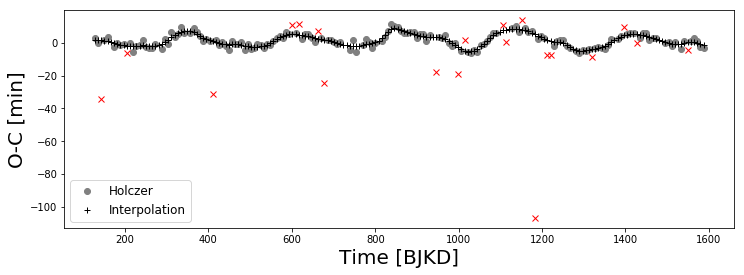

optimizing logp for variables: [logjit, mean, log_rho_off, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: -74.20264997556012 -> 390.2760214661867


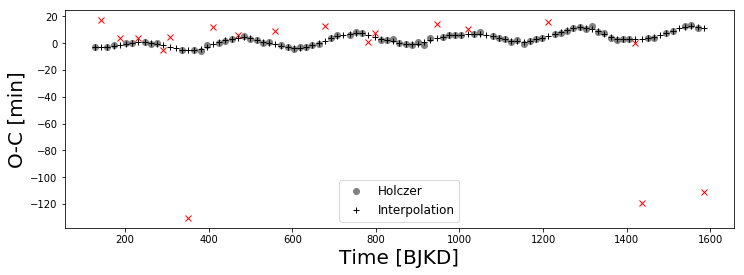

optimizing logp for variables: [logjit, mean, log_rho_off, log_sigma]


message: Optimization terminated successfully.
logp: -332.6058725107557 -> 1100.440631718903


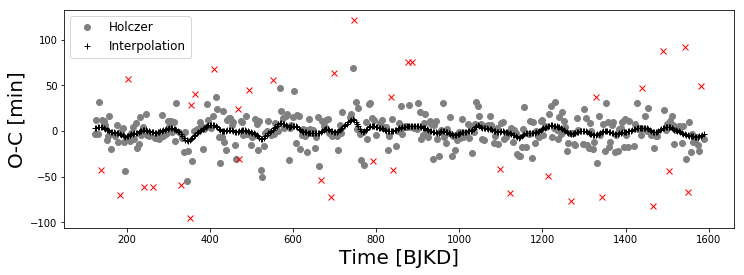

In [18]:
for npl in range(NPL):
    if np.isfinite(holczer_pers[npl]):
        # fit a linear ephemeris 
        pfit  = poly.polyfit(holczer_inds[npl], holczer_tts[npl], 1)
        ephem = poly.polyval(holczer_inds[npl], pfit)
        
        
        # put fitted epoch in range (TIME_START, TIME_START + PERIOD)
        hepoch, hper = pfit

        if hepoch < TIME_START:
            adj = 1 + (TIME_START - hepoch)//hper
            hepoch += adj*hper       

        if hepoch > (TIME_START + hper):
            adj = (hepoch - TIME_START)//hper
            hepoch -= adj*hper      

        hephem = np.arange(hepoch, TIME_END, hper)        
        hinds  = np.array(np.round((hephem-hepoch)/hper),dtype='int')
        
        
        # calculate OMC and flag outliers
        xtime = np.copy(holczer_tts[npl])
        yomc  = (holczer_tts[npl] - ephem)

        ymed = ndimage.median_filter(yomc, size=5, mode="mirror")
        out  = np.abs(yomc-ymed)/astropy.stats.mad_std(yomc-ymed) > 3.0
                
        # set up a GP using a Matern-3/2 kernel
        with pm.Model() as holczer_model:

            dx = np.mean(np.diff(xtime))
            
            # build the kernel
            log_sigma = pm.Normal("log_sigma", mu=np.log(np.std(yomc)), sd=5)
            log_rho_off = pm.Normal("log_rho_off", mu=np.log(4*dx), sd=5)
            rho = pm.Deterministic("rho", 4*dx + T.exp(log_rho_off))
            
            kernel = GPterms.Matern32Term(sigma=T.exp(log_sigma), rho=rho)

            # here's the GP likelihood
            mean = pm.Normal("mean", mu=np.mean(yomc), sd=np.std(yomc))
            logjit = pm.Normal("logjit", mu=np.var(yomc), sd=5)
            
            gp = GaussianProcess(kernel, t=xtime[~out], diag=T.exp(logjit)*T.ones(np.sum(~out)), mean=mean)

            gp.marginal("gp", observed=yomc[~out])

            # track GP prediction
            pred = pm.Deterministic("pred", gp.predict(yomc[~out], hephem))
                                    

        # find the MAP solution
        with holczer_model:
            holczer_map = pmx.optimize()
            
        htts = hephem + holczer_map["pred"]

        holczer_inds[npl] = np.copy(hinds)
        holczer_tts[npl] = np.copy(htts)
            
            
        # plot the results
        plt.figure(figsize=(12,4))
        plt.plot(xtime[~out], yomc[~out]*24*60, 'o', c="grey", label="Holczer")
        plt.plot(xtime[out], yomc[out]*24*60, "rx")
        plt.plot(hephem, (htts-hephem)*24*60, "k+", label="Interpolation")
        plt.xlabel("Time [BJKD]", fontsize=20)
        plt.ylabel("O-C [min]", fontsize=20)
        plt.legend(fontsize=12)
        plt.show()

In [19]:
# check if Holczer TTVs exist, and if so, replace the linear ephemeris
holczer_transit_times = []

for npl, p in enumerate(planets):
    match = np.isclose(holczer_pers, p.period, rtol=0.1, atol=DURS.max())
    
    if np.sum(match) > 1:
        raise ValueError("Something has gone wrong matching periods between DR25 and Holczer+ 2016")
        
    if np.sum(match) == 1:
        loc = np.squeeze(np.where(match))
    
        hinds = holczer_inds[loc]
        htts  = holczer_tts[loc]
        
        for i, t0 in enumerate(p.tts):
            for j, tH in enumerate(htts):
                if np.abs(t0-tH)/p.period < 0.25:
                    p.tts[i] = tH
                    
        holczer_transit_times.append(np.copy(p.tts))
        
        
    else:
        holczer_transit_times.append(None)

In [20]:
# plot the OMC TTVs
fig, axes = plt.subplots(NPL, figsize=(12,3*NPL))
if NPL == 1: axes = [axes]

for npl, p in enumerate(planets):
    xtime = poly.polyval(p.index, poly.polyfit(p.index, p.tts, 1))
    yomc  = (p.tts - xtime)*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
axes[0].set_title(TARGET, fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_initial.png', bbox_inches='tight')
plt.show()

In [21]:
FULL_FIXED_EPHEMERIS = []
FULL_FIXED_INDS = []

for npl, p in enumerate(planets):
    FULL_FIXED_EPHEMERIS.append(poly.polyval(p.index, poly.polyfit(p.index, p.tts, 1)))
    FULL_FIXED_INDS.append(np.copy(p.index - p.index.min()))

# Detrend the lightcurves

In [22]:
# set break tolerance and nominal minimum oscillation period
break_tolerance = np.max([int(DURS.min()/(LCIT/60/24)*5/2), 13])
min_period = 1.0


for i, lcd in enumerate(lc_data):
    print("QUARTER {}".format(lcd.quarter[0]))
    
    qmask = lk.KeplerQualityFlags.create_quality_mask(lcd.quality, bitmask="default")
    lcd.remove_flagged_cadences(qmask)
    
    # make transit mask
    lcd.mask = np.zeros(len(lcd.time), dtype="bool")
    for npl, p in enumerate(planets):
        lcd.mask += detrend.make_transitmask(lcd.time, p.tts, np.max([1/24,1.5*p.duration]))
    
    lcd.clip_outliers(kernel_size=13, sigma_upper=5, sigma_lower=5, mask=lcd.mask)
    lcd.clip_outliers(kernel_size=13, sigma_upper=5, sigma_lower=1000, mask=None)
    
    try:
        lcd = detrend.flatten_with_gp(lcd, break_tolerance, min_period)
    except:
        warnings.warn("Initial detrending model failed...attempting to refit without exponential ramp component")
        try:
            lcd = detrend.flatten_with_gp(lcd, break_tolerance, min_period, correct_ramp=False)
        except:
            warnings.warn("Detrending with RotationTerm failed...attempting to detrend with SHOTerm")
            lcd = detrend.flatten_with_gp(lcd, break_tolerance, min_period, kterm="SHOTerm", correct_ramp=False)

QUARTER 0


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -372.77847125057724 -> -372.77847125057724


optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -372.77847125057724 -> 2866.31257296465


optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Optimization terminated successfully.
logp: 2866.31257296465 -> 2872.996573129312
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 2872.996573129312 -> 2873.713725107993
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 2873.713725107993 -> 2873.882531084087
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 2873.882531084087 -> 2873.9073933265036
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Optimization terminated successfully.
logp: 2873.9073933265036 -> 2873.912455706862


QUARTER 1


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -1314.1703514349863 -> -1314.1703514349863


optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -1314.1703514349863 -> 10475.774004303543


optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 10475.774004303543 -> 10482.280608316485
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 10482.280608316485 -> 10482.330342347934
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Optimization terminated successfully.
logp: 10482.330342347934 -> 10482.337687249152


optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Optimization terminated successfully.
logp: 10482.337687249152 -> 10482.33877521632


optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 10482.33877521632 -> 10482.339030153053


QUARTER 2


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -3145.769316948017 -> -3145.769316948017
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -3145.769316948017 -> 23303.38142135646
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 23303.38142135646 -> 24402.866582900722
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 24402.866582900722 -> 24407.362793011278
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Optimization terminated successfully.
logp: 24407.362793011278 -> 24407.581523721597
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Optimization terminated successfully.
logp: 24407.581523721597 -> 24407.587438643477
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 24407.587438643477 -> 24407.587675856965


In [23]:
if len(lc_data) > 0:
    lc = detrend.stitch(lc_data)
else:
    lc = None

In [24]:
# set break tolerance and nominal minimum oscillation period
break_tolerance = np.max([int(DURS.min()/(SCIT/3600/24)*5/2), 91])
min_period = 1.0


for i, scd in enumerate(sc_data):
    print("QUARTER {}".format(scd.quarter[0]))
    
    qmask = lk.KeplerQualityFlags.create_quality_mask(scd.quality, bitmask="default")
    scd.remove_flagged_cadences(qmask)
    
    # make transit mask
    scd.mask = np.zeros(len(scd.time), dtype="bool")
    for npl, p in enumerate(planets):
        scd.mask += detrend.make_transitmask(scd.time, p.tts, np.max([1/24,1.5*p.duration]))
    
    scd.clip_outliers(kernel_size=13, sigma_upper=5, sigma_lower=5, mask=scd.mask)
    scd.clip_outliers(kernel_size=13, sigma_upper=5, sigma_lower=1000, mask=None)
    
    try:
        scd = detrend.flatten_with_gp(scd, break_tolerance, min_period)
    except:
        warnings.warn("Initial detrending model failed...attempting to refit without exponential ramp component")
        try:
            scd = detrend.flatten_with_gp(scd, break_tolerance, min_period, correct_ramp=False)
        except:
            warnings.warn("Detrending with RotationTerm failed...attempting to detrend with SHOTerm")
            scd = detrend.flatten_with_gp(scd, break_tolerance, min_period, kterm="SHOTerm", correct_ramp=False)

QUARTER 3


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -97930.23504761551 -> -97930.23504761551
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -97930.23504761551 -> 611253.0478928251
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 611253.0478928251 -> 611857.3263916512
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 611857.3263916512 -> 611869.5333972342
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 611869.5333972342 -> 611871.6446620984
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 611871.6446620984 -> 611871.7285008541
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 611871.7285008541 -> 611871.7285008541


QUARTER 4


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -96556.57192505735 -> -96556.57192505726
optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -96556.57192505726 -> 595813.0016918707
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 595813.0016918707 -> 596000.3251580397
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 596000.3251580397 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 596000.3251580397 -> 596000.3251580443
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 596000.3251580443 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 596000.3251580443 -> 596012.7816630468


QUARTER 5


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -106334.60044420026 -> -106334.60044420026
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -106334.60044420026 -> 671674.956484854
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 671674.956484854 -> 671873.3162917984
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 671873.3162917984 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 671873.3162917984 -> 671873.3162918012
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 671873.3162918012 -> 671880.3723879011
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 671880.3723879011 -> 671881.0320243825


QUARTER 6


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -99680.65887278464 -> -99680.65887278464
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -99680.65887278464 -> 624730.9466355263
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 624730.9466355263 -> 625199.7175837192
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 625199.7175837192 -> 625203.494427539
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 625203.494427539 -> 625204.2655577237
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 625204.2655577237 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 625204.2655577237 -> 625206.5762746612


QUARTER 7


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -99460.3509090981 -> -99460.3509090981
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -99460.3509090981 -> 619906.1486980098
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 619906.1486980098 -> 620132.4806177331
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 620132.4806177331 -> 620140.3198412689
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 620140.3198412689 -> 620153.5125451982
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 620153.5125451982 -> 620154.3981738976
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 620154.3981738976 -> 620154.4760494045


QUARTER 8


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -73253.98455041213 -> -73253.98455041213
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -73253.98455041213 -> 449525.7075298243
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 449525.7075298243 -> 450032.473061494
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 450032.473061494 -> 450033.5642867939
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 450033.5642867939 -> 450033.6161984937
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 450033.6161984937 -> 450033.6201900219
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 450033.6201900219 -> 450033.62061892764


QUARTER 9


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -110053.57896057937 -> -110053.57896057937
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -110053.57896057937 -> 694990.4296362532
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 694990.4296362532 -> 695589.9084736535
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 695589.9084736535 -> 695591.2254178982
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 695591.2254178982 -> 695591.2811883985
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 695591.2811883985 -> 695591.2814914369
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 695591.2814914369 -> 695591.2814958247


QUARTER 10


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -103840.73459618192 -> -103840.73459618192
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -103840.73459618192 -> 650597.5933594309
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 650597.5933594309 -> 650828.3760453529
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 650828.3760453529 -> 650830.0668332255
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 650830.0668332255 -> 650830.0951927501
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 650830.0951927501 -> 650830.1202712223
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 650830.1202712223 -> 650830.1202712234


QUARTER 11


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -104190.20247790725 -> -104190.20247790725
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -104190.20247790725 -> 647623.6644895526
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 647623.6644895526 -> 648030.6883195206
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 648030.6883195206 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 648030.6883195206 -> 648030.688319522
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 648030.688319522 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 648030.688319522 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


QUARTER 12


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -83481.55404111515 -> -83481.55404111458
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -83481.55404111458 -> 512245.8543860215
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 512245.8543860215 -> 512475.8616950403
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 512475.8616950403 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 512475.8616950403 -> 512475.8616950417
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 512475.8616950417 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 512475.8616950417 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


QUARTER 13


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -99893.07924245234 -> -99893.07924245234
optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -99893.07924245234 -> 627418.8342063699
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 627418.8342063699 -> 627804.4049415059
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 627804.4049415059 -> 627809.1538070478
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 627809.1538070478 -> 627809.5080351946
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 627809.5080351946 -> 627809.6483649694
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 627809.6483649694 -> 627809.7402876434


QUARTER 14


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -99902.25062949694 -> -99902.25062949694
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -99902.25062949694 -> 625115.3926024892
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 625115.3926024892 -> 625502.0025190328
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 625502.0025190328 -> 625513.3151507644
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 625513.3151507644 -> 625515.332957408
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 625515.332957408 -> 625515.5290498497
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 625515.5290498497 -> 625515.6581693552


QUARTER 15


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -102558.10952466237 -> -102558.10952466237
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -102558.10952466237 -> 636637.2987458699
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 636637.2987458699 -> 636903.634288548
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 636903.634288548 -> 636910.2168783965
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 636910.2168783965 -> 636911.6491732755
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 636911.6491732755 -> 636911.67366527
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 636911.67366527 -> 636911.673911373


QUARTER 16


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -83340.40687090329 -> -83340.40687090329
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -83340.40687090329 -> 512078.14911538386
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 512078.14911538386 -> 512273.39254223433
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Optimization terminated successfully.
logp: 512273.39254223433 -> 512278.8323744039
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 512278.8323744039 -> 512279.11744577036
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 512279.11744577036 -> 512279.19012264407
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 512279.19012264407 -> 512279.2213601206


QUARTER 17


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -30007.498797527005 -> -30007.498797527005


optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -30007.498797527005 -> 188537.3223718304
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 188537.3223718304 -> 188703.35125014852
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 188703.35125014852 -> 188707.6324573282
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 188707.6324573282 -> 188708.85469264747
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 188708.85469264747 -> 188708.85815220707
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 188708.85815220707 -> 188708.85815220716


In [25]:
if len(sc_data) > 0:
    sc = detrend.stitch(sc_data)
else:
    sc = None

# Make wide masks that track each planet individually
### These masks have width 2.5 transit durations, which is probably wider than the masks used for detrending

In [26]:
if sc is not None:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, np.max([2/24,2.5*p.duration]))
        
    sc.mask = sc_mask.sum(axis=0) > 0

else:
    sc_mask = None

    
if lc is not None:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, np.max([2/24,2.5*p.duration]))
        
    lc.mask = lc_mask.sum(axis=0) > 0

else:
    lc_mask = None

# Flag high quality transits (quality = 1)

### Good transits must have  at least 50% photometry coverage in/near transit

In [27]:
for npl, p in enumerate(planets):
    count_expect_lc = int(np.ceil(p.duration/lcit))
    count_expect_sc = int(np.ceil(p.duration/scit))
        
    quality = np.zeros(len(p.tts), dtype="bool")
    
    for i, t0 in enumerate(p.tts):
        
        if sc is not None:
            in_sc = np.abs(sc.time - t0)/p.duration < 0.5
            near_sc = np.abs(sc.time - t0)/p.duration < 1.5
            
            qual_in = np.sum(in_sc) > 0.5*count_expect_sc
            qual_near = np.sum(near_sc) > 1.5*count_expect_sc
            
            quality[i] += qual_in*qual_near
        
        
        if lc is not None:
            in_lc = np.abs(lc.time - t0)/p.duration < 0.5
            near_lc = np.abs(lc.time - t0)/p.duration < 1.5
            
            qual_in = np.sum(in_lc) > 0.5*count_expect_lc
            qual_near = np.sum(near_lc) > 1.5*count_expect_lc
            
            quality[i] += qual_in*qual_near
            
    
    p.quality = np.copy(quality)

# Flag which transits overlap (overlap = 1)

In [28]:
# identify overlapping transits
dur_max = np.max(DURS)
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(planets[i].tts), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for ttj in planets[j].tts:
                overlap[i] += np.abs(planets[i].tts - ttj)/dur_max < 1.5
                
    planets[i].overlap = np.copy(overlap[i])

# Count up transits and calculate initial fixed transit times

In [29]:
num_transits = np.zeros(NPL)
transit_inds = []
fixed_tts = []

for npl, p in enumerate(planets):
    transit_inds.append(np.array((p.index - p.index.min())[p.quality], dtype="int"))
    fixed_tts.append(np.copy(p.tts)[p.quality])
    
    num_transits[npl] = len(transit_inds[npl])
    transit_inds[npl] -= transit_inds[npl].min()

# Grab the relevant data

In [30]:
# grab data near transits for each quarter
all_time = [None]*18
all_flux = [None]*18
all_error = [None]*18
all_dtype = ["none"]*18

lc_flux = []
sc_flux = []


for q in range(18):
    if sc is not None:
        if np.isin(q, sc.quarter):
            use = (sc.mask)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time[q] = sc.time[use]
                all_flux[q] = sc.flux[use]
                all_error[q] = sc.error[use]
                all_dtype[q] = "short"

                sc_flux.append(sc.flux[use])
                
            else:
                all_dtype[q] = "short_no_transits"

    
    if lc is not None:
        if np.isin(q, lc.quarter):
            use = (lc.mask)*(lc.quarter == q)

            if np.sum(use) > 5:
                all_time[q] = lc.time[use]
                all_flux[q] = lc.flux[use]
                all_error[q] = lc.error[use]
                all_dtype[q] = "long"

                lc_flux.append(lc.flux[use])
                
            else:
                all_dtype[q] = "long_no_transits"

In [31]:
# check which quarters have data and transits
good = (np.array(all_dtype) == "short") + (np.array(all_dtype) == "long")
quarters = np.arange(18)[good]
nq = len(quarters)


# make some linear flux arrays (for convenience use laster)
try: sc_flux_lin = np.hstack(sc_flux)
except: sc_flux_lin = np.array([])
    
try: lc_flux_lin = np.hstack(lc_flux)
except: lc_flux_lin = np.array([])
    
try:
    good_flux = np.hstack([sc_flux_lin, lc_flux_lin])
except:
    try:
        good_flux = np.hstack(sc_flux)
    except:
        good_flux = np.hstack(lc_flux)

In [32]:
# set oversampling factors and expoure times
oversample = np.zeros(18, dtype="int")
texp = np.zeros(18)

oversample[np.array(all_dtype)=="short"] = 1
oversample[np.array(all_dtype)=="long"] = 15

texp[np.array(all_dtype)=="short"] = scit
texp[np.array(all_dtype)=="long"] = lcit

# Pull basic transit parameters

In [33]:
periods   = np.zeros(NPL)
epochs    = np.zeros(NPL)
depths    = np.zeros(NPL)
durations = np.zeros(NPL)
impacts   = np.zeros(NPL)

for npl, p in enumerate(planets):
    periods[npl]   = p.period
    epochs[npl]    = p.epoch
    depths[npl]    = p.depth
    durations[npl] = p.duration
    impacts[npl]   = p.impact

radii = np.sqrt(depths)*RSTAR

In [34]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  1344 s



# (1) Fit transit SHAPE model

In [35]:
print('\n(1) Fitting transit SHAPE model')


(1) Fitting transit SHAPE model


In [36]:
# use Legendre polynomials for better orthogonality; "x" is in the range (-1,1)
Leg0 = []
Leg1 = []
Leg2 = []
Leg3 = []
t = []

# this assumes a baseline in the range (TIME_START,TIME_END)
for npl, p in enumerate(planets):    
    t.append(p.epoch + transit_inds[npl]*p.period)
    x = 2*(t[npl]-TIME_START)/(TIME_END-TIME_START) - 1

    Leg0.append(np.ones_like(x))
    Leg1.append(x.copy())
    Leg2.append(0.5*(3*x**2 - 1))
    Leg3.append(0.5*(5*x**3 - 3*x))

In [37]:
with pm.Model() as shape_model:
    # place informative priors on stellar density
    logrho = pm.Normal("logrho", mu=LOGRHO, sd=LOGRHO_ERR)
    rho = pm.Deterministic("rho", 10**logrho)
    
    # planetary parameters
    log_ror = pm.Uniform("logror", lower=np.log(1e-5), upper=np.log(1.0), shape=NPL)
    ror = pm.Deterministic("ror", T.exp(log_ror))
    rp = pm.Deterministic("rp", ror*RSTAR)
        
    beta = pm.Exponential('beta', lam=1, testval=-np.log(impacts), shape=NPL)
    b    = pm.Deterministic('b', T.exp(-beta))
    
    # polynomial TTV parameters    
    C0 = pm.Normal('C0', mu=0.0, sd=durations/2, shape=NPL)
    C1 = pm.Normal('C1', mu=0.0, sd=durations/2, shape=NPL)
    
    transit_times = []
    for npl in range(NPL):
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), 
                                              fixed_tts[npl] + C0[npl]*Leg0[npl] + C1[npl]*Leg1[npl]))
    
    
    # set up stellar model and planetary orbit
    starrystar = exo.LimbDarkLightCurve(UCOEFFS)
    orbit = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, 
                                 b=b, r_star=RSTAR, rho_star=rho)
    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # nuissance parameters
    flux0 = pm.Normal('flux0', mu=np.mean(good_flux), sd=np.std(good_flux), shape=len(quarters))
    logjit = pm.Normal('logjit', mu=np.var(good_flux), sd=10, shape=len(quarters))

    
    # now evaluate the model for each quarter
    light_curves = [None]*nq
    model_flux = [None]*nq
    obs = [None]*nq
    
    for j, q in enumerate(quarters):
        # calculate light curves
        light_curves[j] = starrystar.get_light_curve(orbit=orbit, r=rp, t=all_time[q], 
                                                     oversample=oversample[j], texp=texp[j])
        
        model_flux[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(all_time[q]))
        pm.Deterministic('model_flux_{0}'.format(j), model_flux[j])
        
        obs[j] = pm.Normal("obs_{0}".format(j), 
                           mu=model_flux[j], 
                           sd=T.sqrt(T.exp(logjit[j])), 
                           observed=all_flux[q])

In [38]:
with shape_model:
    shape_map = shape_model.test_point
    shape_map = pmx.optimize(start=shape_map, vars=[flux0, logjit])
    shape_map = pmx.optimize(start=shape_map, vars=[b, rp, rho])
    shape_map = pmx.optimize(start=shape_map, vars=[C0, C1])
    shape_map = pmx.optimize(start=shape_map)

optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -401367.1341339394 -> 2360603.8698361344
optimizing logp for variables: [logrho, logror, beta]


message: Optimization terminated successfully.
logp: 2360603.8698361344 -> 2451431.6972184903
optimizing logp for variables: [C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 2451431.6972184903 -> 2451527.156606628
optimizing logp for variables: [logjit, flux0, C1, C0, beta, logror, logrho]


message: Desired error not necessarily achieved due to precision loss.
logp: 2451527.156606628 -> 2500143.047182354


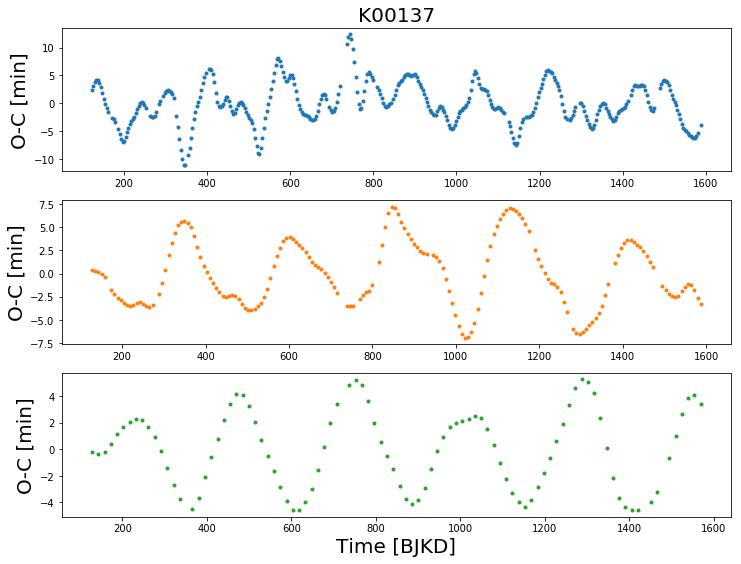

In [39]:
# grab transit times and ephemeris
shape_transit_times = []
shape_ephemeris = []

for npl, p in enumerate(planets):
    shape_transit_times.append(shape_map['tts_{0}'.format(npl)])
    shape_ephemeris.append(shape_map['P'][npl]*transit_inds[npl] + shape_map['T0'][npl])

    
# plot the OMC TTVs
fig, axes = plt.subplots(NPL, figsize=(12,3*NPL))
if NPL == 1: axes = [axes]

for npl, p in enumerate(planets):
    xtime = shape_transit_times[npl]
    yomc  = (shape_transit_times[npl] - shape_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
axes[0].set_title(TARGET, fontsize=20)
plt.show()

In [40]:
# update parameter values
Mstar   = shape_map["rho"]/RHOSUN_GCM3 * RSTAR**3
rho     = shape_map["rho"]

periods = shape_map['P']
epochs  = shape_map['T0']
rp      = shape_map['rp']
b       = shape_map['b']

sma     = get_sma(periods, Mstar)
durs    = get_dur_tot(periods, rp, RSTAR, b, sma)


for npl, p in enumerate(planets):
    p.period   = periods[npl]
    p.epoch    = epochs[npl]
    p.depth    = get_transit_depth(rp[npl]/RSTAR, b[npl])
    p.duration = durs[npl]
    p.impact   = b[npl]

In [41]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  1647 s



# (2) Fit slide TTVs

In [42]:
print('\n(2) Fitting SLIDE TTVs')


(2) Fitting SLIDE TTVs


In [43]:
slide_transit_times = []
slide_error = []

t_all = np.array(np.hstack(all_time), dtype="float")
f_all = np.array(np.hstack(all_flux), dtype="float")

for npl, p in enumerate(planets):
    print("\nPLANET", npl)
    
    slide_transit_times.append([])
    slide_error.append([])
    
    # create template transit
    starrystar = exo.LimbDarkLightCurve(UCOEFFS)
    orbit  = exo.orbits.KeplerianOrbit(t0=0, period=p.period, b=b[npl], r_star=RSTAR, m_star=Mstar)

    gridstep     = scit/2
    slide_offset = 1.0
    delta_chisq  = 2.0

    template_time = np.arange(-(0.02+p.duration)*(slide_offset+1.6), (0.02+p.duration)*(slide_offset+1.6), gridstep)
    template_flux = 1.0 + starrystar.get_light_curve(orbit=orbit, r=rp[npl], t=template_time).sum(axis=-1).eval()
    
    
    # empty lists to hold new transit time and uncertainties
    tts = -99*np.ones_like(shape_transit_times[npl])
    err = -99*np.ones_like(shape_transit_times[npl])
    
    for i, t0 in enumerate(shape_transit_times[npl]):
        #print(i, np.round(t0,2))
        if ~p.overlap[p.quality][i]:
        
            # grab flux near each non-overlapping transit
            use = np.abs(t_all - t0)/p.duration < 2.5
            mask = np.abs(t_all - t0)/p.duration < 1.0

            t_ = t_all[use]
            f_ = f_all[use]
            m_ = mask[use]
            
            
            # remove any residual out-of-transit trend
            try:
                trend = poly.polyval(t_, poly.polyfit(t_[~m_], f_[~m_], 1))
            
                f_ /= trend
                e_ = np.ones_like(f_)*np.std(f_[~m_])
                
            except:
                e_ = np.ones_like(f_)*np.std(f_)
            

            # slide along transit time vector and calculate chisq
            tc_vector = t0 + np.arange(-p.duration*slide_offset, p.duration*slide_offset, gridstep)
            chisq_vector = np.zeros_like(tc_vector)

            for j, tc in enumerate(tc_vector):
                y_ = np.interp(t_-tc, template_time, template_flux)
                chisq_vector[j] = np.sum((f_ - y_)**2/e_**2)

            chisq_vector = boxcar_smooth(chisq_vector, winsize=7)


            # grab points near minimum chisq
            delta_chisq = 1
            
            loop = True
            while loop:
                # incrememnt delta_chisq and find minimum
                delta_chisq += 1
                min_chisq = chisq_vector.min()
                
                # grab the points near minimum
                tcfit = tc_vector[chisq_vector < min_chisq+delta_chisq]
                x2fit = chisq_vector[chisq_vector < min_chisq+delta_chisq]

                # eliminate points far from the local minimum
                spacing = np.median(tcfit[1:]-tcfit[:-1])
                faraway = np.abs(tcfit-np.median(tcfit))/spacing > 1 + len(tcfit)/2
                
                tcfit = tcfit[~faraway]
                x2fit = x2fit[~faraway]
                
                # check for stopping conditions
                if len(x2fit) >= 3:
                    loop = False
                    
                if delta_chisq >= 9:
                    loop = False
                    
                    
            # fit a parabola around the minimum (need at least 3 pts)
            if len(tcfit) < 3:
                #print("TOO FEW POINTS")
                tts[i] = np.nan
                err[i] = np.nan

            else:
                quad_coeffs = np.polyfit(tcfit, x2fit, 2)
                quadfit = np.polyval(quad_coeffs, tcfit)
                qtc_min = -quad_coeffs[1]/(2*quad_coeffs[0])
                qx2_min = np.polyval(quad_coeffs, qtc_min)
                qtc_err = np.sqrt(1/quad_coeffs[0])

                # here's the fitted transit time
                tts[i] = np.mean([qtc_min,np.median(tcfit)])
                err[i] = qtc_err*1.0

                # check that the fit is well-conditioned (ie. a negative t**2 coefficient)
                if quad_coeffs[0] <= 0.0:
                    #print("INVERTED PARABOLA")
                    tts[i] = np.nan
                    err[i] = np.nan

                # check that the recovered transit time is within the expected range
                if (tts[i] < tcfit.min()) or (tts[i] > tcfit.max()):
                    #print("T0 OUT OF BOUNDS")
                    tts[i] = np.nan
                    err[i] = np.nan


            # show plots
            if ~np.isnan(tts[i]):
                do_plots = False
                    
                if do_plots:
                    fig, ax = plt.subplots(1,2, figsize=(10,3))

                    ax[0].plot(t_-tts[i], f_, "ko")
                    ax[0].plot((t_-tts[i])[m_], f_[m_], "o", c="C{0}".format(npl))
                    ax[0].plot(template_time, template_flux, c="C{0}".format(npl), lw=2)

                    ax[1].plot(tcfit, x2fit, "ko")
                    ax[1].plot(tcfit, quadfit, c="C{0}".format(npl), lw=3)
                    ax[1].axvline(tts[i], color="k", ls="--", lw=2)

                    plt.show()

        else:
            #print("OVERLAPPING TRANSITS")
            tts[i] = np.nan
            err[i] = np.nan
        
    slide_transit_times[npl] = np.copy(tts)
    slide_error[npl] = np.copy(err)


PLANET 0


/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in sqrt



PLANET 1

PLANET 2


In [44]:
for npl, p in enumerate(planets):
    bad = np.isnan(slide_transit_times[npl]) + np.isnan(slide_error[npl])
    bad += slide_error[npl] > 8*np.nanmedian(slide_error[npl])
    
    slide_transit_times[npl][bad] = shape_transit_times[npl][bad]
    slide_error[npl][bad] = np.nan

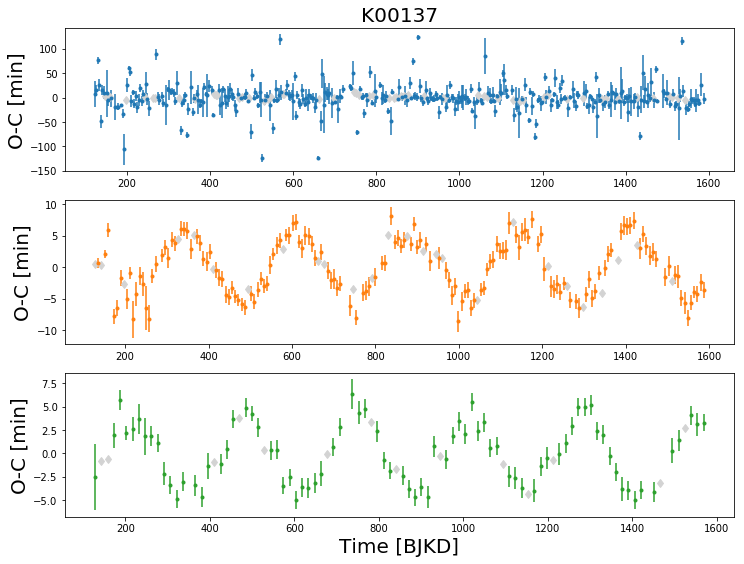

In [45]:
# grab transit times and ephemeris
# plot the OMC TTVs
fig, axes = plt.subplots(NPL, figsize=(12,3*NPL))
if NPL == 1: axes = [axes]

for npl, p in enumerate(planets):
    ephem = poly.polyval(transit_inds[npl], poly.polyfit(transit_inds[npl], slide_transit_times[npl], 1))
    
    xtime = slide_transit_times[npl]
    yomc  = (slide_transit_times[npl] - ephem)*24*60
    yerr  = slide_error[npl]*24*60
    
    good = ~np.isnan(slide_error[npl])
    
    axes[npl].plot(xtime[~good], yomc[~good], "d", color="lightgrey")
    axes[npl].errorbar(xtime[good], yomc[good], yerr=yerr[good], fmt='.', color='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
axes[0].set_title(TARGET, fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_slide.png', bbox_inches='tight')
plt.show()

# (3) Fit MAP independent TTVs

### Only refit transit times for which the slide method failed

In [46]:
print('\n(3) Fitting INDEPENDENT TTVs')


(3) Fitting INDEPENDENT TTVs


In [47]:
if sc is not None:
    sc_map_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        tts = slide_transit_times[npl][np.isnan(slide_error[npl])]
        sc_map_mask[npl] = detrend.make_transitmask(sc.time, tts, np.max([2/24,2.5*p.duration]))
        
    sc_map_mask = sc_map_mask.sum(axis=0) > 0

else:
    sc_map_mask = None

    
if lc is not None:
    lc_map_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        tts = slide_transit_times[npl][np.isnan(slide_error[npl])]
        lc_map_mask[npl] = detrend.make_transitmask(lc.time, tts, np.max([2/24,2.5*p.duration]))
        
    lc_map_mask = lc_map_mask.sum(axis=0) > 0

else:
    lc_map_mask = None

In [48]:
# grab data near transits for each quarter
map_time = [None]*18
map_flux = [None]*18
map_dtype = ["none"]*18


for q in range(18):
    if sc is not None:
        if np.isin(q, sc.quarter):
            use = (sc_map_mask)*(sc.quarter == q)

            if np.sum(use) > 45:
                map_time[q] = sc.time[use]
                map_flux[q] = sc.flux[use]
                map_dtype[q] = "short"
                
            else:
                map_dtype[q] = "short_no_transits"

    
    if lc is not None:
        if np.isin(q, lc.quarter):
            use = (lc_map_mask)*(lc.quarter == q)

            if np.sum(use) > 5:
                map_time[q] = lc.time[use]
                map_flux[q] = lc.flux[use]
                map_dtype[q] = "long"
                
            else:
                map_dtype[q] = "long_no_transits"
                
map_quarters = np.arange(18)[(np.array(map_dtype) == "short") + (np.array(map_dtype) == "long")]

In [49]:
with pm.Model() as indep_model:
    # transit times
    tt_offset = []
    map_tts  = []
    map_inds = []
    
    for npl in range(NPL):
        use = np.isnan(slide_error[npl])
        
        tt_offset.append(pm.Normal("tt_offset_{0}".format(npl), mu=0, sd=1, shape=np.sum(use)))
        
        map_tts.append(pm.Deterministic("tts_{0}".format(npl),
                                        slide_transit_times[npl][use] + tt_offset[npl]*durations[npl]/3))
        
        map_inds.append(transit_inds[npl][use])
    
    # set up stellar model and planetary orbit
    starrystar = exo.LimbDarkLightCurve(UCOEFFS)
    orbit  = exo.orbits.TTVOrbit(transit_times=map_tts, transit_inds=map_inds, 
                                 b=b, r_star=RSTAR, m_star=Mstar)
    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # nuissance parameters
    flux0 = pm.Normal('flux0', mu=np.mean(good_flux), sd=np.std(good_flux), shape=len(map_quarters))
    logjit = pm.Normal('logjit', mu=np.var(good_flux), sd=10, shape=len(map_quarters))

    
    # now evaluate the model for each quarter
    light_curves = [None]*len(map_quarters)
    model_flux = [None]*len(map_quarters)
    obs = [None]*len(map_quarters)
    
    for j, q in enumerate(map_quarters):
        # calculate light curves
        light_curves[j] = starrystar.get_light_curve(orbit=orbit, r=rp, t=map_time[q], 
                                                     oversample=oversample[j], texp=texp[j])
        
        model_flux[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(map_time[q]))
        pm.Deterministic('model_flux_{0}'.format(j), model_flux[j])
        
        obs[j] = pm.Normal("obs_{0}".format(j), 
                           mu=model_flux[j], 
                           sd=T.sqrt(T.exp(logjit[j])), 
                           observed=map_flux[q])

In [50]:
with indep_model:
    indep_map = indep_model.test_point
    indep_map = pmx.optimize(start=indep_map, vars=[flux0, logjit])
    
    for npl in range(NPL):
        indep_map = pmx.optimize(start=indep_map, vars=[tt_offset[npl]])
        
    indep_map = pmx.optimize(start=indep_map)

optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -43170.35329535814 -> 267049.2318481727
optimizing logp for variables: [tt_offset_0]


message: Desired error not necessarily achieved due to precision loss.
logp: 267049.2318481727 -> 267087.7505877612
optimizing logp for variables: [tt_offset_1]


message: Desired error not necessarily achieved due to precision loss.
logp: 267087.7505877612 -> 267119.4519987066
optimizing logp for variables: [tt_offset_2]


message: Desired error not necessarily achieved due to precision loss.
logp: 267119.4519987066 -> 267137.46641994285
optimizing logp for variables: [logjit, flux0, tt_offset_2, tt_offset_1, tt_offset_0]


message: Desired error not necessarily achieved due to precision loss.
logp: 267137.46641994285 -> 267138.300641849


In [51]:
indep_transit_times = []
indep_error = []
indep_ephemeris = []
full_indep_ephemeris = []

for npl, p in enumerate(planets):
    indep_transit_times.append(np.copy(slide_transit_times[npl]))
    indep_error.append(np.copy(slide_error[npl]))
    
    replace = np.isnan(slide_error[npl])
    
    indep_transit_times[npl][replace] = indep_map["tts_{0}".format(npl)]
    
    pfit = poly.polyfit(transit_inds[npl], indep_transit_times[npl], 1)
    
    indep_ephemeris.append(poly.polyval(transit_inds[npl], pfit))
    full_indep_ephemeris.append(poly.polyval(p.index, pfit))

    indep_error[npl][replace] = np.std(indep_transit_times[npl] - indep_ephemeris[npl])

    
fig, axes = plt.subplots(NPL, figsize=(12,3*NPL))
if NPL == 1: axes = [axes]

for npl, p in enumerate(planets):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])*24*60
    yerr  = (indep_error[npl])*24*60
    
    axes[npl].errorbar(xtime, yomc, yerr=yerr, fmt='.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
axes[0].set_title(TARGET, fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_indep.png', bbox_inches='tight')
plt.show()

In [52]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  1871 s



# Search for periodic signals in the OMC curves

In [53]:
print("Searching for periodic signals")

Searching for periodic signals


In [54]:
indep_freqs = []
indep_faps = []

for npl, p in enumerate(planets):
    # grab data
    xtime = indep_ephemeris[npl]
    yomc  = indep_transit_times[npl] - indep_ephemeris[npl]

    ymed = boxcar_smooth(ndimage.median_filter(yomc, size=5, mode="mirror"), winsize=5)
    out  = np.abs(yomc-ymed)/astropy.stats.mad_std(yomc-ymed) > 5.0
    
    
    # search for a periodic component
    peakfreq = np.nan
    peakfap = 1.0
    
    if NPL == 1: fap = 0.1
    elif NPL > 1: fap = 0.99
    
    if np.sum(~out) > 8:
        try:
            xf, yf, freqs, faps = LS_estimator(xtime[~out], yomc[~out], fap=fap)

            if len(freqs) > 0:
                if freqs[0] > xf.min():
                    peakfreq = freqs[0]
                    peakfap = faps[0]
        except:
            pass
    
    indep_freqs.append(peakfreq)
    indep_faps.append(peakfap)

In [55]:
omc_freqs = []
omc_faps = []

# for single planet systems, use the direct LS output
if NPL == 1:
    if np.isnan(indep_freqs[0]):
        omc_freqs.append(None)
        omc_faps.append(None)
    else:
        omc_freqs.append(indep_freqs[0])
        omc_faps.append(indep_faps[0])
    

# for multiplanet systems, check if any statistically marginal frequencies match between planets
elif NPL > 1:
    
    for i in range(NPL):
        # save any low FAP frequencies
        if indep_faps[i] < 0.1:
            omc_freqs.append(indep_freqs[i])
            omc_faps.append(indep_faps[i])
            
        # check if the LS frequency is close to that of any other planet
        else:
            close = False
            
            df_min = 1/(indep_ephemeris[i].max() - indep_ephemeris[i].min())
            
            for j in range(i+1, NPL):
                # delta-freq (LS) between two planets
                df_ij = np.abs(indep_freqs[i]-indep_freqs[j])
                
                if df_ij < df_min:
                    close = True
                    
            if close:
                omc_freqs.append(indep_freqs[i])
                omc_faps.append(indep_faps[i])
                
            else:
                omc_freqs.append(None)
                omc_faps.append(None)


PLANET 0

PLANET 1
periodic component found at P = 265 d


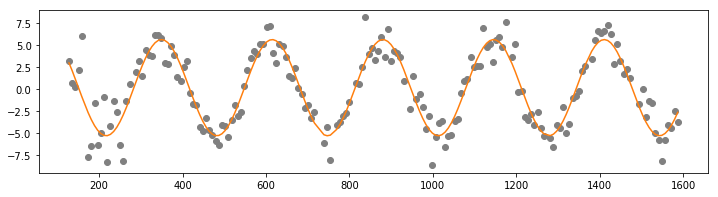


PLANET 2
periodic component found at P = 266 d


In [56]:
omc_pers = []

for npl in range(NPL):
    print("\nPLANET", npl)
    
    # roughly model OMC based on single frequency sinusoid (if found)
    if omc_freqs[npl] is not None:
        print("periodic component found at P =", int(1/omc_freqs[npl]), "d")
        
        # store frequency
        omc_pers.append(1/omc_freqs[npl])
        
        # grab data and plot
        xtime = indep_ephemeris[npl]
        yomc  = indep_transit_times[npl] - indep_ephemeris[npl]
        LS = LombScargle(xtime, yomc)
        
        plt.figure(figsize=(12,3))
        plt.plot(xtime, yomc*24*60, "o", c="grey")
        plt.plot(xtime, LS.model(xtime, omc_freqs[npl])*24*60, c="C{0}".format(npl))
        plt.show()
    
    else:
        omc_pers.append(None)

# Determine best OMC model

In [57]:
print("Determining best OMC model")

Determining best OMC model


In [58]:
def build_omc_model(xtime, yomc, polyorder=1, period=None, use_gp=False, xt_predict=None):
    """
    Build a PyMC3 model to fit TTV observed-minus-calculated data
    Assumes a functional from with a polynomial (up to cubic) plus a (optional) single-frequency sinusoid
    
    Parameters
    ----------
        xtime : ndarray
            time values (e.g. linear ephemeris)
        yomc : ndarray
            observed-minus-caculated TTVs
        polyorder : int
            polynomial order (default=1)
        period : float (optional)
            if provided, the model will include a sinusoid component with tight priors on this period
        use_gp : bool
            True to include a Matern-3/2 covariance GP in addition to the parametric polynomial + sinusoid
        xt_predict : ndarray
            time values to predict OMC model; if not provided xtime will be used
            
    Returns
    -------
        model : pm.Model()
    """    
    with pm.Model() as model:
        # periodic component
        if period is None:
            f  = 1/(xtime.max()-xtime.min())
            Ah = 0.0
            Bk = 0.0
            
        else:
            df = 1/(xtime.max()-xtime.min())
            f  = pm.Normal("f", mu=1/period, sd=df)
            Ah = pm.Normal("Ah", mu=0, sd=5*np.std(yomc))
            Bk = pm.Normal("Bk", mu=0, sd=5*np.std(yomc))
            
            
        def sin_fxn(A, B, f, xt):
            return A*T.sin(2*pi*f*xt) + B*T.cos(2*pi*f*xt)
            
        sin_trend = pm.Deterministic("sin_trend", sin_fxn(Ah, Bk, f, xtime))
        
        
        # polynomical component
        C0 = pm.Normal("C0", mu=0, sd=10)
        C1 = 0.0
        C2 = 0.0
        C3 = 0.0

        if polyorder >= 1: C1 = pm.Normal("C1", mu=0, sd=10)
        if polyorder >= 2: C2 = pm.Normal("C2", mu=0, sd=10)
        if polyorder >= 3: C3 = pm.Normal("C3", mu=0, sd=10)
        if polyorder >= 4: raise ValueError("only configured for 3rd order polynomials")
        
        def poly_fxn(c0, c1, c2, c3, xt):
            return c0 + c1*xt + c2*xt**2 + c3*xt**3
        
        poly_trend = pm.Deterministic("poly_trend", poly_fxn(C0, C1, C2, C3, xtime))
        
        
        # mean and jitter
        mean = pm.Deterministic("mean", sin_trend + poly_trend)
        logjit = pm.Normal("logjit", mu=np.log(np.var(yomc-sig.medfilt(yomc,kernel_size=5))), sd=10)
        
        
        # times where trend will be predicted
        if xt_predict is None:
            xt_predict = xtime

        
        if use_gp:
            # build the kernel and gp
            dx = np.mean(np.diff(xtime))
            
            log_sigma = pm.Normal("log_sigma", mu=np.log(np.std(yomc)), sd=5)
            log_rho_off = pm.Normal("log_rho_off", mu=np.log(4*dx), sd=5)
            rho = pm.Deterministic("rho", 4*dx + T.exp(log_rho_off))
            
            kernel = GPterms.Matern32Term(sigma=T.exp(log_sigma), rho=rho)

            gp = GaussianProcess(kernel, t=xtime, diag=T.exp(logjit)*T.ones(len(xtime)), mean=mean)

            gp.marginal("gp", observed=yomc)


        else:
            # here's the likelihood
            pm.Normal("obs", mu=mean, sd=T.sqrt(T.exp(logjit)*T.ones(len(xtime))), observed=yomc)
            
        
        # track GP prediction and trend
        full_mean_pred = pm.Deterministic("full_mean_pred", 
                                          sin_fxn(Ah,Bk,f,xt_predict) + 
                                          poly_fxn(C0,C1,C2,C3,xt_predict))
            
    return model

In [59]:
def build_mix_model(x):
    """
    Build a 1D PyMC3 mixture model
    The model is composed of two Normal distributions with the same mean but different variances
    
    Parameters
    ----------
        x : ndarray
            vector of data values
            
    Returns
    -------
        model : pm.Model()    
    """
    
    xnorm = x / np.std(x)
    xnorm -= np.mean(xnorm)
    
    with pm.Model() as model:
        
        # mixture parameters
        w = pm.Dirichlet("w", np.array([1.,1.]))
        mu = pm.Normal("mu", mu=0.0, sd=1.0, shape=1)
        tau = pm.Gamma("tau", 1.0, 1.0, shape=2)
        
        # here's the potential
        obs = pm.NormalMixture("obs", w, mu=mu*T.ones(2), tau=tau, observed=xnorm)
        
    return model

In [60]:
def flag_res_outliers(res, loc, scales):
    """
    Flag outliers in a residuals vector using a mixture model
    Assigns residuals to either a narrow foreground distribution or a wide background distribution
    
    
    Parameters
    ----------
        res : ndarray (N)
            vector of residuals
        loc : float
            normal mean inferred from build_mix_model()
        scales : tuple
            normal standard deviations inferred from build_mix_model()
            
    Returns
    -------
        fg_prob : ndarray (N)
            probability the each item in res belongs to the foreground distribution
        bad : bool (N)
            binary classification of each item in res into foreground/background distribution
    """
    
    resnorm = residuals/np.std(residuals)
    resnorm -= np.mean(resnorm)
    
    order = np.argsort(scales)
    scales = scales[order]
    
    z_fg = stats.norm(loc=loc, scale=scales[0]).pdf(resnorm)
    z_bg = stats.norm(loc=loc, scale=scales[1]).pdf(resnorm)

    fg_prob = z_fg/(z_fg+z_bg)
    fg_prob = (fg_prob - fg_prob.min())/(fg_prob.max()-fg_prob.min())


    # use KMeans clustering to assign each point to the foreground or background
    km = KMeans(n_clusters=2)
    group = km.fit_predict(fg_prob.reshape(-1,1))
    centroids = np.array([np.mean(fg_prob[group==0]), np.mean(fg_prob[group==1])])

    bad = group == np.argmin(centroids)
        
    return fg_prob, bad


PLANET 0


optimizing logp for variables: [C1, C0]


message: Optimization terminated successfully.
logp: 1111.2121888820816 -> 1112.963955277602


optimizing logp for variables: [logjit, C1, C0]


message: Optimization terminated successfully.
logp: 1112.963955277602 -> 1118.972377611915


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C1, C0]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 47 seconds.


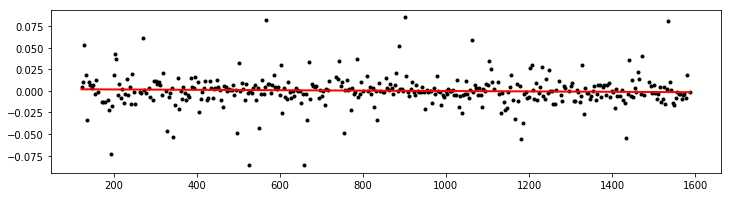

Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]


Sampling 1 chain for 3_000 tune and 1_000 draw iterations (3_000 + 1_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


polyorder: 1
loc: [-0.009]
scale: [1.954 0.444]
75 outliers found out of 390 transit times (19.2%)
AIC: -3885.4
BIC: -3869.6


optimizing logp for variables: [C1, C0]


message: Optimization terminated successfully.
logp: 1107.9906652558827 -> 1109.7424316514034


optimizing logp for variables: [C2, C1, C0]


message: Optimization terminated successfully.
logp: 1109.7424316514034 -> 1109.7429883735888


optimizing logp for variables: [logjit, C2, C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 1109.7429883735888 -> 1115.7512899640599
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C2, C1, C0]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 41 seconds.


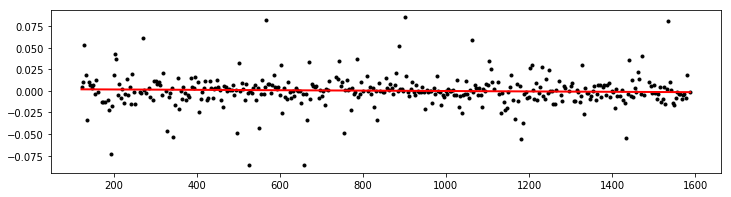

Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]


Sampling 1 chain for 3_000 tune and 1_000 draw iterations (3_000 + 1_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


polyorder: 2
loc: [-0.01]
scale: [1.953 0.442]
75 outliers found out of 390 transit times (19.2%)
AIC: -3883.6
BIC: -3863.7


optimizing logp for variables: [C1, C0]


message: Optimization terminated successfully.
logp: 1104.769141629684 -> 1106.5209080252046


optimizing logp for variables: [C2, C1, C0]


message: Optimization terminated successfully.
logp: 1106.5209080252046 -> 1106.5214647473902


optimizing logp for variables: [C3, C2, C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 1106.5214647473902 -> 1106.522278159661


optimizing logp for variables: [logjit, C3, C2, C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 1106.522278159661 -> 1106.522278159661


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C3, C2, C1, C0]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 42 seconds.


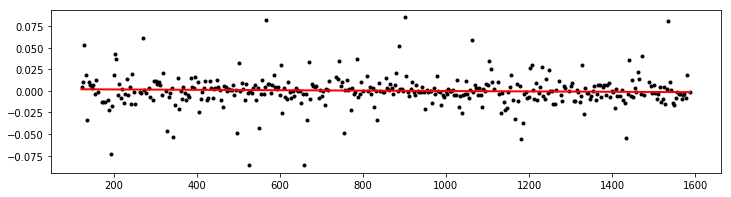

Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]


Sampling 1 chain for 3_000 tune and 1_000 draw iterations (3_000 + 1_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


polyorder: 3
loc: [-0.01]
scale: [0.443 1.953]
75 outliers found out of 390 transit times (19.2%)
AIC: -3881.4
BIC: -3857.6


optimizing logp for variables: [logjit, C1, C0]


message: Optimization terminated successfully.
logp: 1110.1174464997355 -> 1116.438096192399


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C1, C0]


Sampling 2 chains for 10_000 tune and 2_000 draw iterations (20_000 + 4_000 draws total) took 50 seconds.


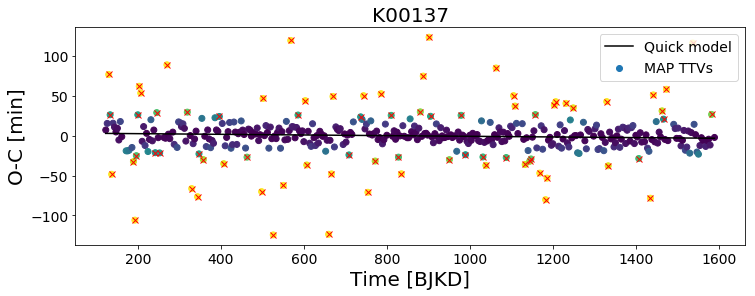


PLANET 1


optimizing logp for variables: [Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 300.3257971864978 -> 974.2829159010691


optimizing logp for variables: [C1, C0]


message: Optimization terminated successfully.
logp: 974.2829159010691 -> 976.2145889128564


optimizing logp for variables: [logjit, C1, C0, Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 976.2145889128564 -> 976.4877193341644
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C1, C0, Bk, Ah, f]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 44 seconds.


Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]


Sampling 1 chain for 3_000 tune and 1_000 draw iterations (3_000 + 1_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


polyorder: 1
loc: [-0.011]
scale: [1.607 0.729]
31 outliers found out of 180 transit times (17.2%)
AIC: -2631.0
BIC: -2618.2


optimizing logp for variables: [Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 297.10427356029913 -> 971.0613922748704


optimizing logp for variables: [C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 971.0613922748704 -> 972.9930652866525
optimizing logp for variables: [C2, C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 972.9930652866525 -> 973.2680026026898


optimizing logp for variables: [logjit, C2, C1, C0, Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 973.2680026026898 -> 973.3458497177209


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C2, C1, C0, Bk, Ah, f]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 45 seconds.


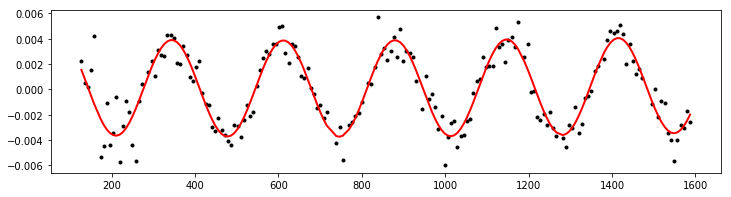

Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]


Sampling 1 chain for 3_000 tune and 1_000 draw iterations (3_000 + 1_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


polyorder: 2
loc: [-0.009]
scale: [0.732 1.607]
32 outliers found out of 180 transit times (17.8%)
AIC: -2633.9
BIC: -2617.9


optimizing logp for variables: [Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 293.8827499341004 -> 967.8398686486717


optimizing logp for variables: [C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 967.8398686486717 -> 969.7715416604536
optimizing logp for variables: [C2, C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 969.7715416604536 -> 970.046478976491


optimizing logp for variables: [C3, C2, C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 970.046478976491 -> 970.0472145138649


optimizing logp for variables: [logjit, C3, C2, C1, C0, Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 970.0472145138649 -> 970.0472145138649


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C3, C2, C1, C0, Bk, Ah, f]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 237 seconds.
There were 782 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]


Sampling 1 chain for 3_000 tune and 1_000 draw iterations (3_000 + 1_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


polyorder: 3
loc: [0.282]
scale: [1.658 0.242]
58 outliers found out of 180 transit times (32.2%)
AIC: -506.1
BIC: -486.9


optimizing logp for variables: [Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: -851.899301102945 -> 870.5574041259104
optimizing logp for variables: [logjit, C2, C1, C0, Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 870.5574041259104 -> 877.8400888125425
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C2, C1, C0, Bk, Ah, f]


Sampling 2 chains for 10_000 tune and 2_000 draw iterations (20_000 + 4_000 draws total) took 59 seconds.


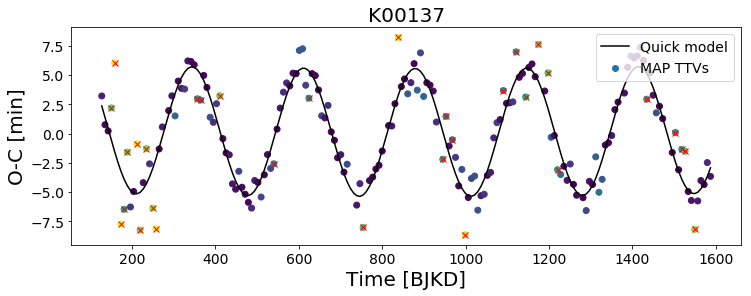


PLANET 2


optimizing logp for variables: [Bk, Ah, f]


message: Optimization terminated successfully.
logp: 121.61517313890367 -> 532.8337554574084


optimizing logp for variables: [C1, C0]


message: Optimization terminated successfully.
logp: 532.8337554574084 -> 535.2033681230447


optimizing logp for variables: [logjit, C1, C0, Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 535.2033681230447 -> 538.5099245308606


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C1, C0, Bk, Ah, f]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 43 seconds.


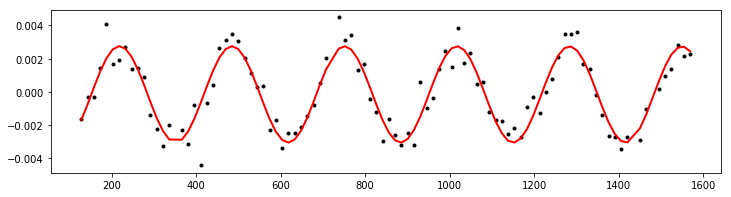

Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]


Sampling 1 chain for 3_000 tune and 1_000 draw iterations (3_000 + 1_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


polyorder: 1
loc: [-0.003]
scale: [0.93  1.258]
4 outliers found out of 94 transit times (4.3%)
AIC: -1374.8
BIC: -1364.7


optimizing logp for variables: [Bk, Ah, f]


message: Optimization terminated successfully.
logp: 118.39364951270495 -> 529.6122318312098


optimizing logp for variables: [C1, C0]


message: Optimization terminated successfully.
logp: 529.6122318312098 -> 531.981844496846


optimizing logp for variables: [C2, C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 531.981844496846 -> 533.4102365166134


optimizing logp for variables: [logjit, C2, C1, C0, Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 533.4102365166134 -> 536.4046179021967


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C2, C1, C0, Bk, Ah, f]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 44 seconds.


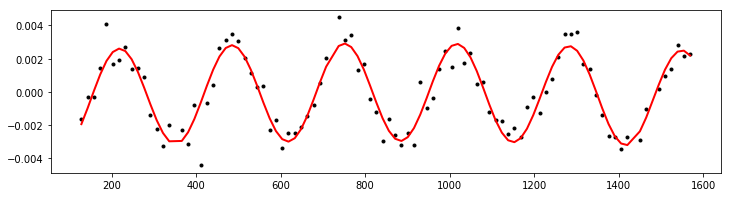

Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]


Sampling 1 chain for 3_000 tune and 1_000 draw iterations (3_000 + 1_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


polyorder: 2
loc: [0.019]
scale: [1.168 0.947]
4 outliers found out of 94 transit times (4.3%)
AIC: -1375.6
BIC: -1362.9


optimizing logp for variables: [Bk, Ah, f]


message: Optimization terminated successfully.
logp: 115.17212588650624 -> 526.390708205011


optimizing logp for variables: [C1, C0]


message: Optimization terminated successfully.
logp: 526.390708205011 -> 528.7603208706473


optimizing logp for variables: [C2, C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 528.7603208706473 -> 530.1887128904146


optimizing logp for variables: [C3, C2, C1, C0]


message: Desired error not necessarily achieved due to precision loss.
logp: 530.1887128904146 -> 530.469884494842


optimizing logp for variables: [logjit, C3, C2, C1, C0, Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 530.469884494842 -> 533.7218591237673


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C3, C2, C1, C0, Bk, Ah, f]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 450 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


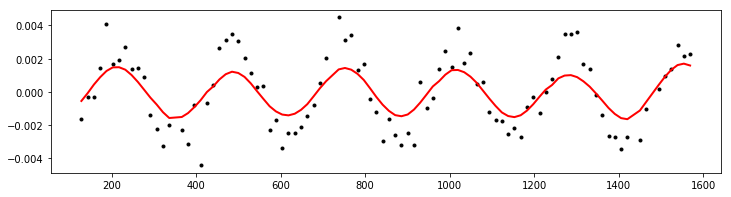

Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]


Sampling 1 chain for 3_000 tune and 1_000 draw iterations (3_000 + 1_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


polyorder: 3
loc: [-0.011]
scale: [1.009 0.997]
18 outliers found out of 94 transit times (19.1%)
AIC: -1305.2
BIC: -1289.9


optimizing logp for variables: [Bk, Ah, f]


message: Optimization terminated successfully.
logp: -248.6369407915521 -> 520.71752461803


optimizing logp for variables: [logjit, C2, C1, C0, Bk, Ah, f]


message: Desired error not necessarily achieved due to precision loss.
logp: 520.71752461803 -> 536.7260778006028


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, C2, C1, C0, Bk, Ah, f]


Sampling 2 chains for 10_000 tune and 2_000 draw iterations (20_000 + 4_000 draws total) took 59 seconds.


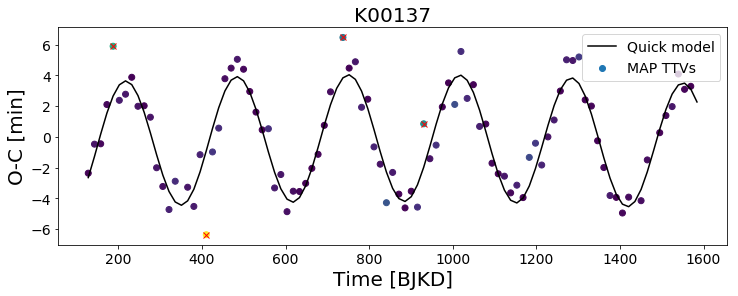

In [61]:
matern_ephemeris = []
matern_transit_times = []

outlier_prob = []
outlier_class = []

for npl, p in enumerate(planets):
    print("\nPLANET", npl)
    
    # grab data
    xtime = indep_ephemeris[npl]
    yomc  = indep_transit_times[npl] - indep_ephemeris[npl]

    ymed = boxcar_smooth(ndimage.median_filter(yomc, size=5, mode="mirror"), winsize=5)
    out  = np.abs(yomc-ymed)/astropy.stats.mad_std(yomc-ymed) > 5.0
    
    
    # compare various models
    aiclist = []
    biclist = []
    outlist = []
    fgplist = []
    
    if np.sum(~out) >= 16: max_polyorder = 3
    elif np.sum(~out) >= 8: max_polyorder = 2
    else: max_polyorder = 1
    
    for polyorder in range(1, max_polyorder+1):
        
        # build the OMC model
        omc_model = build_omc_model(xtime[~out], yomc[~out], polyorder=polyorder, 
                                    period=omc_pers[npl], use_gp=False, xt_predict=xtime)

        with omc_model:
            omc_map = omc_model.test_point
            
            if omc_pers[npl] is not None:
                omc_map = pmx.optimize(start=omc_map, vars=[omc_model.f, omc_model.Ah, omc_model.Bk])
            if polyorder >= 1:
                omc_map = pmx.optimize(start=omc_map, vars=[omc_model.C0, omc_model.C1])
            if polyorder >= 2:
                omc_map = pmx.optimize(start=omc_map, vars=[omc_model.C0, omc_model.C1, omc_model.C2])
            if polyorder >= 3:
                omc_map = pmx.optimize(start=omc_map, vars=[omc_model.C0, omc_model.C1, omc_model.C2, omc_model.C3])
                
            omc_map = pmx.optimize(start=omc_map)
            omc_trace = pmx.sample(tune=5000, draws=1000, start=omc_map, chains=2, target_accept=0.9)

        
        # flag outliers via mixture model of the residuals
        omc_trend = np.nanmedian(omc_trace["full_mean_pred"], 0)
        residuals = yomc - omc_trend
        
        
        plt.figure(figsize=(12,3))
        plt.plot(xtime, yomc, "k.")
        plt.plot(xtime, omc_trend, "r", lw=2)
        plt.show()
        
        mix_model = build_mix_model(residuals)
        
        with mix_model:
            mix_trace = pmx.sample(tune=3000, draws=1000, chains=1, target_accept=0.9)

        loc = np.nanmedian(mix_trace["mu"], axis=0)
        scales = np.nanmedian(1/np.sqrt(mix_trace["tau"]), axis=0)

        fg_prob, bad = flag_res_outliers(residuals, loc, scales)
        
        outlist.append(bad)
        fgplist.append(fg_prob)
        
        print("polyorder:", polyorder)
        print("loc:", np.round(loc,3))
        print("scale:", np.round(scales,3))
        print("{0} outliers found out of {1} transit times ({2}%)".format(np.sum(bad), len(bad), 
                                                                          np.round(100.*np.sum(bad)/len(bad),1)))
        
        # calculate AIC & BIC
        n = len(yomc)
        k = polyorder + 3
        
        AIC = n*np.log(np.sum(residuals[~bad]**2)/np.sum(~bad)) + 2*k
        BIC = n*np.log(np.sum(residuals[~bad]**2)/np.sum(~bad)) + k*np.log(n)
        
        aiclist.append(AIC)
        biclist.append(BIC)
        
        print("AIC:", np.round(AIC,1))
        print("BIC:", np.round(BIC,1))
      
    
    # choose the best model and recompute
    bad = outlist[np.argmin(aiclist)]
    polyorder = 1 + np.argmin(aiclist)
    
    
    omc_model = build_omc_model(xtime[~bad], yomc[~bad], polyorder=polyorder, period=omc_pers[npl], 
                                use_gp=False, xt_predict = full_indep_ephemeris[npl])

    with omc_model:
        omc_map = omc_model.test_point
        if omc_pers[npl] is not None:
            omc_map = pmx.optimize(start=omc_map, vars=[omc_model.f, omc_model.Ah, omc_model.Bk])
        omc_map = pmx.optimize(start=omc_map)
        omc_trace = pmx.sample(tune=10000, draws=1000, start=omc_map, chains=2, target_accept=0.95)
    

    omc_trend = np.nanmean(omc_trace["full_mean_pred"], 0)
    fg_prob = fgplist[np.argmin(aiclist)]

    # save the final results
    mtts = full_indep_ephemeris[npl] + omc_trend
    mephem = poly.polyval(p.index, poly.polyfit(p.index, mtts, 1))
                                                                          
    matern_transit_times.append(mtts)
    matern_ephemeris.append(mephem) 
    
    outlier_prob.append(1-fg_prob)
    outlier_class.append(bad)
    
    # plot the final trend and outliers
    plt.figure(figsize=(12,4))
    plt.scatter(xtime, yomc*24*60, c=1-fg_prob, cmap="viridis", label="MAP TTVs")
    plt.plot(xtime[bad], yomc[bad]*24*60, "rx")
    plt.plot(full_indep_ephemeris[npl], omc_trend*24*60, "k", label="Quick model")
    plt.xlabel("Time [BJKD]", fontsize=20)
    plt.ylabel("O-C [min]", fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14, loc="upper right")
    plt.title(TARGET, fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_omc_model_{0}.png'.format(npl), bbox_inches='tight')
    plt.show()

In [62]:
fig, axes = plt.subplots(NPL, figsize=(12,3*NPL))
if NPL == 1: axes = [axes]

for npl, p in enumerate(planets):
    xtime = matern_transit_times[npl]
    yomc  = (matern_transit_times[npl] - matern_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
axes[0].set_title(TARGET, fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_quick.png', bbox_inches='tight')
plt.show()

# Estimate TTV amplitudes

In [63]:
# get estimate of ttv amplitude and a reasonable buffer
ttv_amps   = np.zeros(NPL)
ttv_buffer = np.zeros(NPL)

for npl in range(NPL):
    # estimate TTV amplitude
    ttv_amps[npl] = astropy.stats.mad_std(indep_transit_times[npl] - indep_ephemeris[npl])

    # based on scatter in independent times, set threshold so not even one outlier is expected
    N   = len(transit_inds[npl])
    eta = np.max([3., stats.norm.interval((N-1)/N)[1]])

    ttv_buffer[npl] = eta*ttv_amps[npl] + lcit

# Update and save TTVs

In [64]:
quick_transit_times = []

for npl in range(NPL):
    p.tts = np.copy(matern_transit_times[npl])
    quick_transit_times.append(p.tts[transit_inds[npl]])
    

for npl in range(NPL):
    # update transit times in planet objects
    p.tts = np.copy(matern_transit_times[npl])
    
    # Save Quick TTVs
    data_out  = np.vstack([transit_inds[npl], quick_transit_times[npl]]).swapaxes(0,1)
    fname_out = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_quick_ttvs.txt'
    
    np.savetxt(fname_out, data_out, fmt=('%1d', '%.8f'), delimiter='\t')
    
    # Save MAP TTVs
    data_out  = np.vstack([transit_inds[npl], indep_transit_times[npl]]).swapaxes(0,1)
    fname_out = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_map_ttvs.txt'
    
    np.savetxt(fname_out, data_out, fmt=('%1d', '%.8f'), delimiter='\t')
    
    
    # Save outlier probabilities
    data_out  = np.vstack([transit_inds[npl], outlier_prob[npl], outlier_class[npl]]).swapaxes(0,1)
    fname_out = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_omc_outlier_info.txt'
    
    np.savetxt(fname_out, data_out, fmt=('%1d', '%.8f', '%1d'), delimiter='\t')
    
    
    # save everything all together
    data_out  = np.vstack([transit_inds[npl],
                           indep_transit_times[npl],
                           quick_transit_times[npl],
                           outlier_prob[npl], 
                           outlier_class[npl]]).swapaxes(0,1)
    fname_out = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_quick.ttvs'
    
    np.savetxt(fname_out, data_out, fmt=('%1d', '%.8f', '%.8f', '%.8f', '%1d'), delimiter='\t')


# Flag outliers based on transit model
#### Cadences must be flagged as outliers from BOTH the Matern model and the Independent model to be rejected

In [65]:
print("Flagging remaining outliers\n")

Flagging remaining outliers



In [66]:
res_i = []
res_m = []

for j, q in enumerate(quarters):
    print("QUARTER", q)
    
    # grab time and flux data
    if all_dtype[q] == "long":
        use = lc.quarter == q
        t_ = lc.time[use]
        f_ = lc.flux[use]
        
    elif all_dtype[q] == "short":
        use = sc.quarter == q
        t_ = sc.time[use]
        f_ = sc.flux[use]
        
    
    # grab transit times for each planet
    wp_i = []
    tts_i = []
    inds_i = []
    
    wp_m = []
    tts_m = []
    inds_m = []
    
    for npl in range(NPL):
        itt = indep_transit_times[npl]
        mtt = matern_transit_times[npl][transit_inds[npl]]
        
        use_i = (itt > t_.min())*(itt < t_.max())
        use_m = (mtt > t_.min())*(mtt < t_.max())
        
        if np.sum(use_i) > 0:
            wp_i.append(npl)
            tts_i.append(itt[use_i])
            inds_i.append(transit_inds[npl][use_i] - transit_inds[npl][use_i][0])
            
        if np.sum(use_m) > 0:
            wp_m.append(npl)
            tts_m.append(itt[use_m])
            inds_m.append(transit_inds[npl][use_m] - transit_inds[npl][use_m][0])
            

    
    # first check independent transit times
    if len(tts) > 0:
        # set up model
        starrystar = exo.LimbDarkLightCurve(UCOEFFS)
        orbit  = exo.orbits.TTVOrbit(transit_times=tts_i, transit_inds=inds_i, period=list(periods[wp_i]), 
                                     b=b[wp_i], r_star=RSTAR, m_star=Mstar)

        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
            texp = scit
        elif all_dtype[q] == 'long':
            oversample = 15
            texp = lcit

        # calculate light curves
        light_curves = starrystar.get_light_curve(orbit=orbit, r=rp[wp_i], t=t_, oversample=oversample, texp=texp)
        model_flux = 1.0 + pm.math.sum(light_curves, axis=-1).eval()

    else:
        model_flux = np.ones_like(f_)*np.mean(f_)
    
    # calculate residuals
    res_i.append(f_ - model_flux)
    
    
    
    # then check matern transit times
    if len(tts) > 0:
        # set up model
        starrystar = exo.LimbDarkLightCurve(UCOEFFS)
        orbit  = exo.orbits.TTVOrbit(transit_times=tts_m, transit_inds=inds_m, period=list(periods[wp_m]), 
                                     b=b[wp_m], r_star=RSTAR, m_star=Mstar)

        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
            texp = scit*1.0
        elif all_dtype[q] == 'long':
            oversample = 15
            texp = lcit*1.0

        # calculate light curves
        light_curves = starrystar.get_light_curve(orbit=orbit, r=rp[wp_m], t=t_, oversample=oversample, texp=texp)
        model_flux = 1.0 + pm.math.sum(light_curves, axis=-1).eval()

    else:
        model_flux = np.ones_like(f_)*np.mean(f_)
    
    # calculate residuals
    res_m.append(f_ - model_flux)

QUARTER 0


/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


QUARTER 1
QUARTER 2
QUARTER 3
QUARTER 4
QUARTER 5
QUARTER 6
QUARTER 7
QUARTER 8
QUARTER 9
QUARTER 10
QUARTER 11
QUARTER 12
QUARTER 13
QUARTER 14
QUARTER 15
QUARTER 16
QUARTER 17


/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)



QUARTER 0
   outliers rejected: 0
   marginal outliers: 0


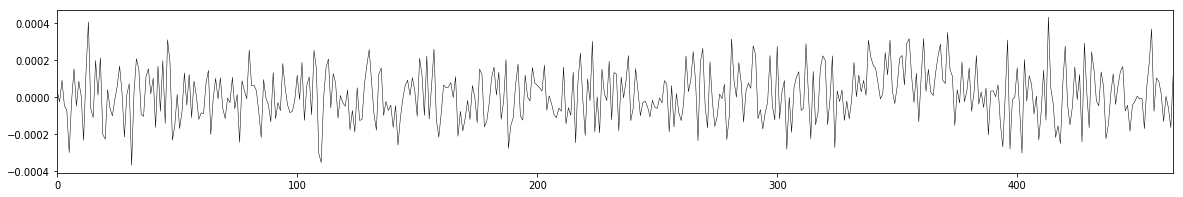


QUARTER 1
   outliers rejected: 0
   marginal outliers: 0



QUARTER 2
   outliers rejected: 1
   marginal outliers: 0


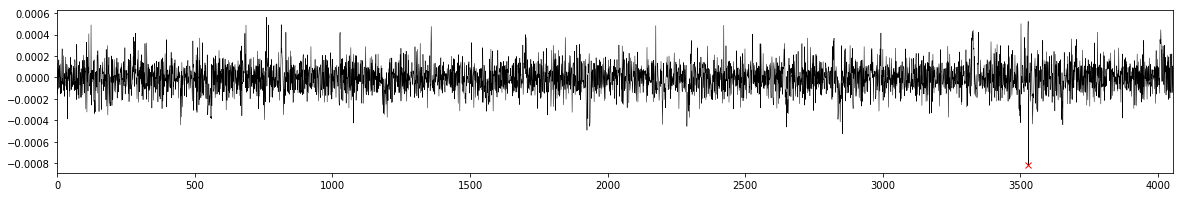


QUARTER 3
   outliers rejected: 0
   marginal outliers: 0


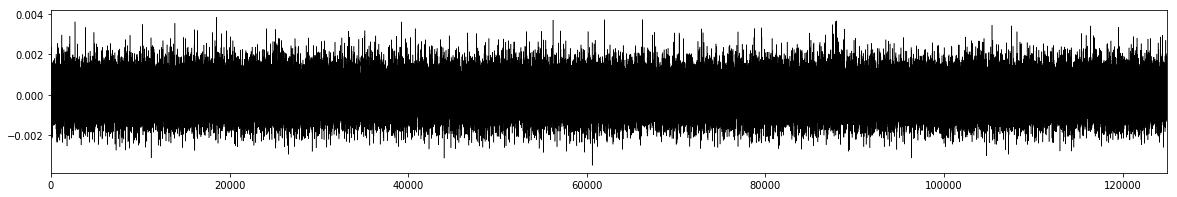


QUARTER 4
   outliers rejected: 2
   marginal outliers: 0


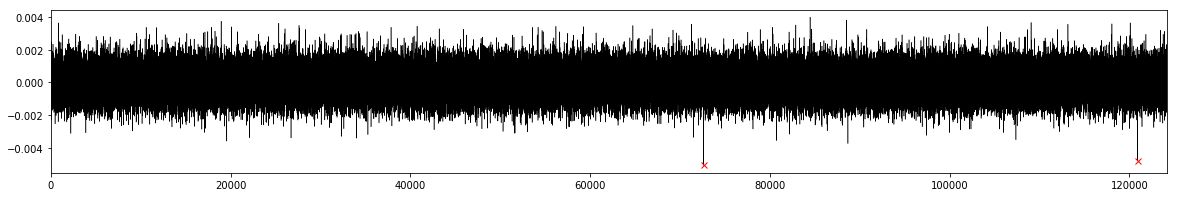


QUARTER 5
   outliers rejected: 4
   marginal outliers: 0


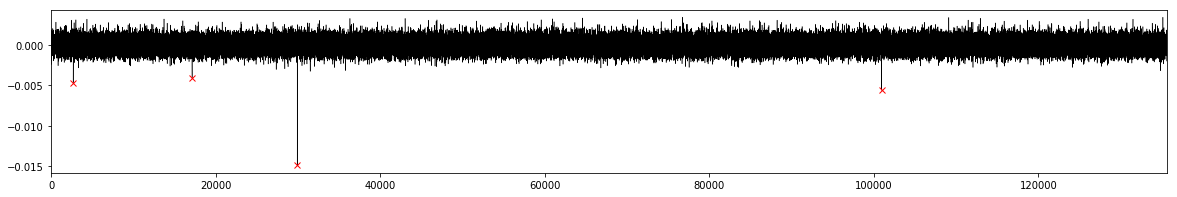


QUARTER 6
   outliers rejected: 1
   marginal outliers: 0


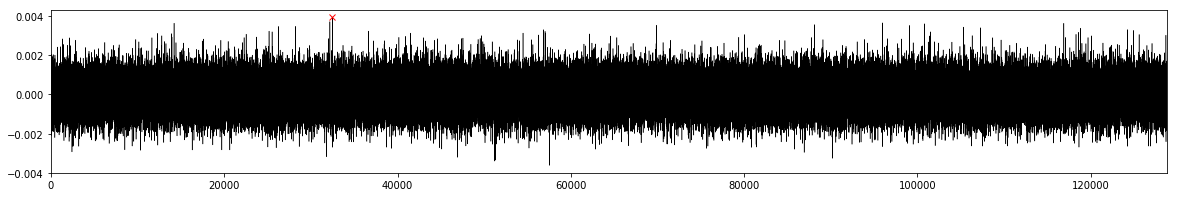


QUARTER 7
   outliers rejected: 1
   marginal outliers: 0


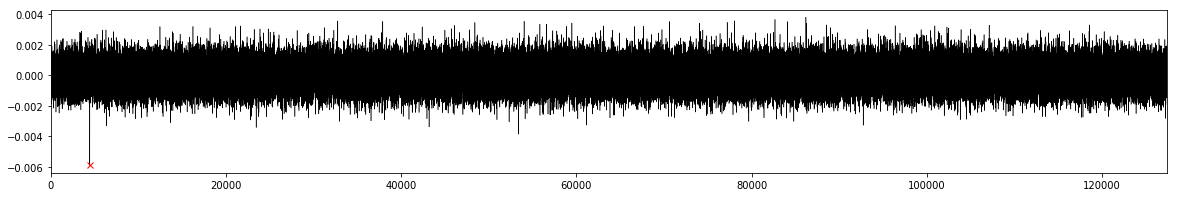


QUARTER 8
   outliers rejected: 3
   marginal outliers: 0


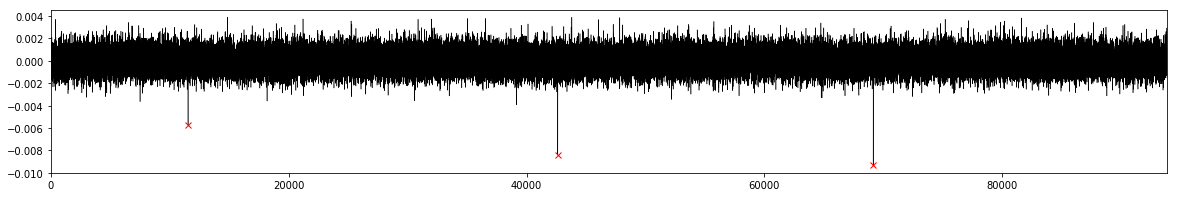


QUARTER 9
   outliers rejected: 5
   marginal outliers: 0


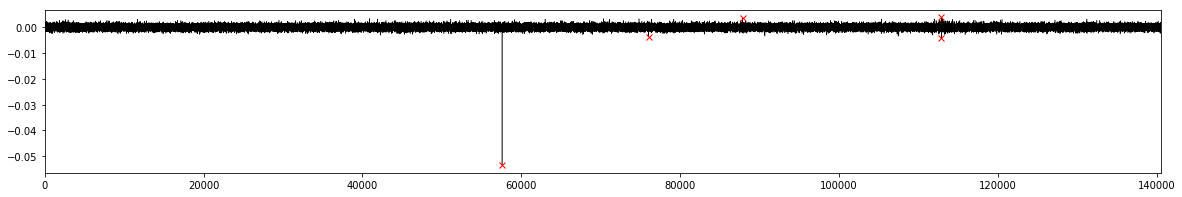


QUARTER 10
   outliers rejected: 0
   marginal outliers: 0


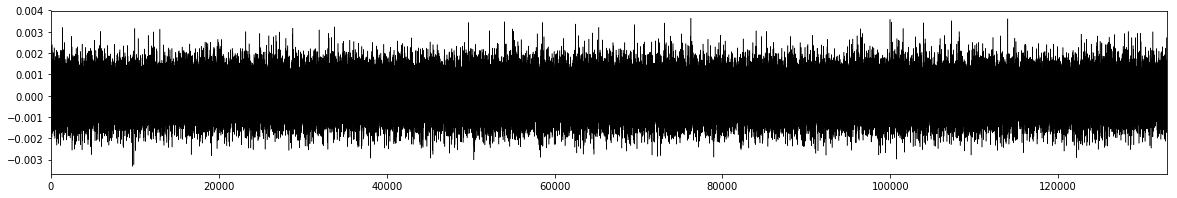


QUARTER 11
   outliers rejected: 3
   marginal outliers: 0


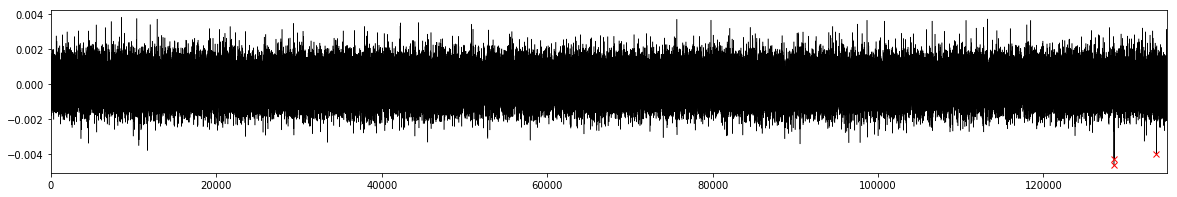


QUARTER 12
   outliers rejected: 7
   marginal outliers: 0


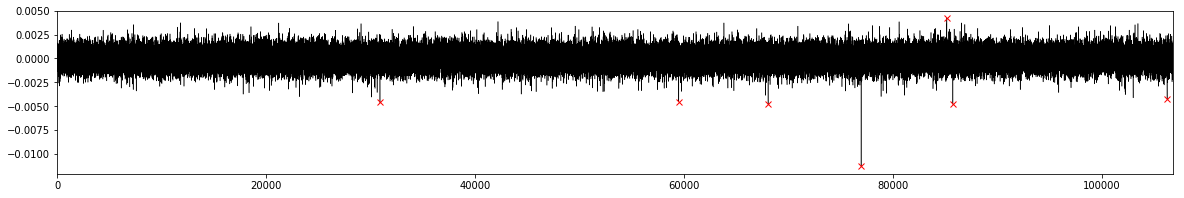


QUARTER 13
   outliers rejected: 73
   marginal outliers: 0


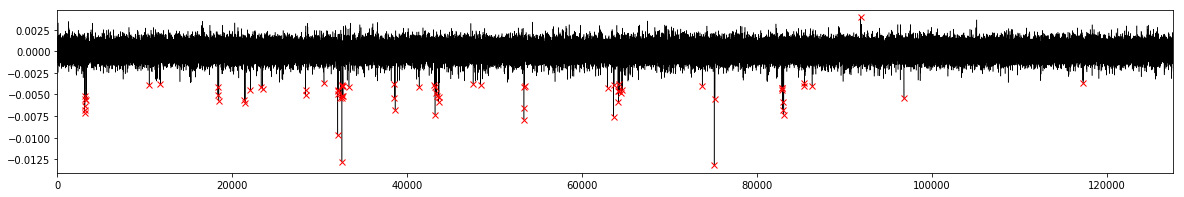


QUARTER 14
   outliers rejected: 1
   marginal outliers: 0



QUARTER 15
   outliers rejected: 0
   marginal outliers: 0


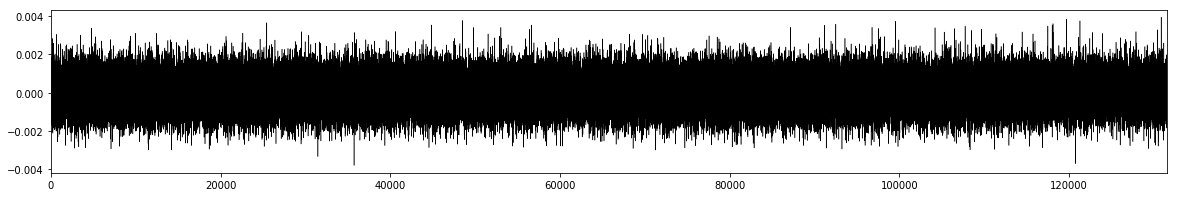


QUARTER 16
   outliers rejected: 16
   marginal outliers: 0



QUARTER 17
   outliers rejected: 28
   marginal outliers: 0


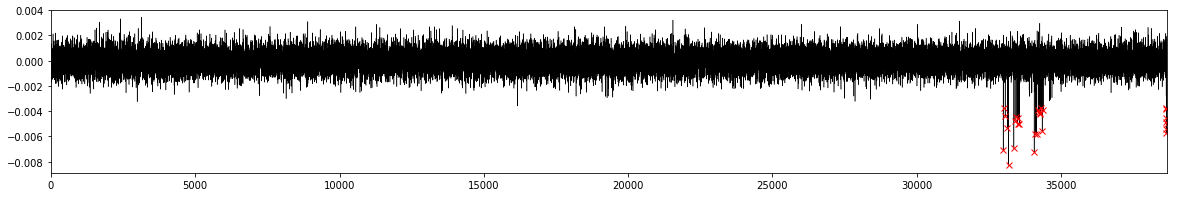

In [67]:
for j, q in enumerate(quarters):
    print("\nQUARTER", q)
    res = 0.5*(res_i[j] + res_m[j])
    x_ = np.arange(len(res))
    
    bad_i = np.abs(res_i[j] - np.mean(res_i[j]))/astropy.stats.mad_std(res_i[j]) > 5.0
    bad_m = np.abs(res_m[j] - np.mean(res_m[j]))/astropy.stats.mad_std(res_m[j]) > 5.0
    
    bad = bad_i * bad_m
    
    print("   outliers rejected:", np.sum(bad))
    print("   marginal outliers:", np.sum(bad_i*~bad_m)+np.sum(~bad_i*bad_m))
    
    plt.figure(figsize=(20,3))
    plt.plot(x_, res, "k", lw=0.5)
    plt.plot(x_[bad], res[bad], "rx")
    plt.xlim(x_.min(), x_.max())
    plt.show()

In [68]:
bad_lc = []
bad_sc = []

for q in range(18):
    if all_dtype[q] == "long_no_transits":
        bad = np.ones(np.sum(lc.quarter == q), dtype="bool")
        bad_lc = np.hstack([bad_lc, bad])
        
        
    if all_dtype[q] == "short_no_transits":
        bad = np.ones(np.sum(sc.quarter == q), dtype="bool")
        bad_sc = np.hstack([bad_sc, bad])    
    
    
    if (all_dtype[q] == "short") + (all_dtype[q] == "long"):
        j = np.where(quarters == q)[0][0]

        res = 0.5*(res_i[j] + res_m[j])
        x_ = np.arange(len(res))

        bad_i = np.abs(res_i[j] - np.mean(res_i[j]))/astropy.stats.mad_std(res_i[j]) > 5.0
        bad_m = np.abs(res_m[j] - np.mean(res_m[j]))/astropy.stats.mad_std(res_m[j]) > 5.0

        bad = bad_i * bad_m

        if all_dtype[q] == "short":
            bad_sc = np.hstack([bad_sc, bad])

        if all_dtype[q] == "long":
            bad_lc = np.hstack([bad_lc, bad])
        
        
bad_lc = np.array(bad_lc, dtype="bool")
bad_sc = np.array(bad_sc, dtype="bool")


if sc is not None:
    good_cadno_sc = sc.cadno[~bad_sc]
    
if lc is not None:
    good_cadno_lc = lc.cadno[~bad_lc]

# Detrend again with better estimates of transit timing

In [69]:
# reset LONG CADENCE to raw MAST downloads
if lc is not None:
    lc_data = detrend.cleanup_lkfc(lc_raw_collection, KIC)
    
# make sure there is at least one transit in the long cadence data
# this shouldn't be an issue for real KOIs, but can happen for simulated data
if np.sum(np.array(all_dtype) == "long") == 0:
    lc_data = []
    
    
lc_quarters = []
for i, lcd in enumerate(lc_data):
    lc_quarters.append(lcd.quarter)

In [70]:
# reset SHORT CADENCE to raw MAST downloads
if sc is not None:
    sc_data = detrend.cleanup_lkfc(sc_raw_collection, KIC)

# make sure there is at least one transit in the short cadence data
# this shouldn't be an issue for real KOIs, but can happen for simulated data
if np.sum(np.array(all_dtype) == "short") == 0:
    sc_data = []
    
    
sc_quarters = []
for i, scd in enumerate(sc_data):
    sc_quarters.append(scd.quarter)

In [71]:
# convert LightKurves to LiteCurves
sc_lite = []
lc_lite = []

for i, scd in enumerate(sc_data):
    sc_lite.append(LightKurve_to_LiteCurve(scd))
    
for i, lcd in enumerate(lc_data):
    lc_lite.append(LightKurve_to_LiteCurve(lcd))
    
    
# renaming here is an artifact of updates to my pipeline and dependencies
# this is easier than going through and fixing all variable names
sc_data = sc_lite
lc_data = lc_lite

In [72]:
# set break tolerance and nominal minimum oscillation period
break_tolerance = np.max([int(DURS.min()/(LCIT/60/24)*5/2), 13])
min_period = 1.0


for i, lcd in enumerate(lc_data):
    print("QUARTER {}".format(lcd.quarter[0]))
    
    qmask = np.isin(lcd.cadno, good_cadno_lc)
    lcd.remove_flagged_cadences(qmask)
    
    # make transit mask
    lcd.mask = np.zeros(len(lcd.time), dtype="bool")
    for npl, p in enumerate(planets):
        masksize = np.max([1/24, 0.5*p.duration + ttv_buffer[npl]])
        lcd.mask += detrend.make_transitmask(lcd.time, p.tts, masksize)
    
    try:
        lcd = detrend.flatten_with_gp(lcd, break_tolerance, min_period)
    except:
        warnings.warn("Initial detrending model failed...attempting to refit without exponential ramp component")
        try:
            lcd = detrend.flatten_with_gp(lcd, break_tolerance, min_period, correct_ramp=False)
        except:
            warnings.warn("Detrending with RotationTerm failed...attempting to detrend with SHOTerm")
            lcd = detrend.flatten_with_gp(lcd, break_tolerance, min_period, kterm="SHOTerm", correct_ramp=False)        

QUARTER 0


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -396.6708770160186 -> -396.6708770160186


optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -396.6708770160186 -> 3053.8934505606503


optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 3053.8934505606503 -> 3063.222034427613
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 3063.222034427613 -> 3064.028257242142
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 3064.028257242142 -> 3064.258219849133
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Optimization terminated successfully.
logp: 3064.258219849133 -> 3064.292975201312
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 3064.292975201312 -> 3064.300692231021


QUARTER 1


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -1381.2528761266021 -> -1381.2528761266021


optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -1381.2528761266021 -> 11017.24977668947


optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Optimization terminated successfully.
logp: 11017.24977668947 -> 11023.805295874234


optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Optimization terminated successfully.
logp: 11023.805295874234 -> 11023.854115936905
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Optimization terminated successfully.
logp: 11023.854115936905 -> 11023.861428287788


optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 11023.861428287788 -> 11023.862463350717
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Optimization terminated successfully.
logp: 11023.862463350717 -> 11023.862683029489



QUARTER 2


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -3381.0082674996825 -> -3381.0082674996825
optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -3381.0082674996825 -> 25172.254365104352
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 25172.254365104352 -> 26290.0012134352
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 26290.0012134352 -> 26294.699323249053
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Optimization terminated successfully.
logp: 26294.699323249053 -> 26294.874905014673
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 26294.874905014673 -> 26294.877260636167
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Optimization terminated successfully.
logp: 26294.877260636167 -> 26294.877302271452


In [73]:
if len(lc_data) > 0:
    lc = detrend.stitch(lc_data)
else:
    lc = None

In [74]:
# set break tolerance and nominal minimum oscillation period
break_tolerance = np.max([int(DURS.min()/(SCIT/3600/24)*5/2), 91])
min_period = 1.0


for i, scd in enumerate(sc_data):
    print("QUARTER {}".format(scd.quarter[0]))
    
    qmask = np.isin(scd.cadno, good_cadno_sc)
    scd.remove_flagged_cadences(qmask)
    
    # make transit mask
    scd.mask = np.zeros(len(scd.time), dtype="bool")
    for npl, p in enumerate(planets):
        masksize = np.max([1/24, 0.5*p.duration + ttv_buffer[npl]])
        scd.mask += detrend.make_transitmask(scd.time, p.tts, masksize)
    
    try:
        scd = detrend.flatten_with_gp(scd, break_tolerance, min_period)
    except:
        warnings.warn("Initial detrending model failed...attempting to refit without exponential ramp component")
        try:
            scd = detrend.flatten_with_gp(scd, break_tolerance, min_period, correct_ramp=False)
        except:
            warnings.warn("Detrending with RotationTerm failed...attempting to detrend with SHOTerm")
            scd = detrend.flatten_with_gp(scd, break_tolerance, min_period, kterm="SHOTerm", correct_ramp=False)

QUARTER 3


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -104649.52028122432 -> -104649.52028122432
optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -104649.52028122432 -> 653125.3236671506
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 653125.3236671506 -> 653778.7246881514
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 653778.7246881514 -> 653789.4356450433
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Optimization terminated successfully.
logp: 653789.4356450433 -> 653790.0305614921
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 653790.0305614921 -> 653790.0360791727
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 653790.0360791727 -> 653790.0603272868


QUARTER 4


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -103432.99625326548 -> -103432.99625326539
optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -103432.99625326539 -> 638228.2846144228
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 638228.2846144228 -> 638424.9047676238
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 638424.9047676238 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 638424.9047676238 -> 638424.9047676265
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 638424.9047676265 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 638424.9047676265 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model



QUARTER 5


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -113358.0474785765 -> -113358.0474785765
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -113358.0474785765 -> 716104.5595381944
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 716104.5595381944 -> 716302.9696145516
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 716302.9696145516 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 716302.9696145516 -> 716302.9696145516
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 716302.9696145516 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 716302.9696145516 -> 716310.3888473524


QUARTER 6


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -107230.66463819571 -> -107230.66463819571
optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -107230.66463819571 -> 672089.8415158495
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 672089.8415158495 -> 672591.0283618007
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 672591.0283618007 -> 672594.9138009174
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 672594.9138009174 -> 672595.7192547488
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 672595.7192547488 -> 672597.1288342901
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 672597.1288342901 -> 672598.0291391566


QUARTER 7


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -106433.2632169496 -> -106433.2632169496
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -106433.2632169496 -> 663160.0608636616
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 663160.0608636616 -> 663401.6950006039
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 663401.6950006039 -> 663410.3598887565
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 663410.3598887565 -> 663418.0564748897
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 663418.0564748897 -> 663418.5207803712
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 663418.5207803712 -> 663418.6202389601


QUARTER 8


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -78315.50174755893 -> -78315.50174755893
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -78315.50174755893 -> 480578.81724544073
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 480578.81724544073 -> 481115.0768647876
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 481115.0768647876 -> 481115.9641644334
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 481115.9641644334 -> 481115.99266784824
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 481115.99266784824 -> 481115.99468572845
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 481115.99468572845 -> 481115.9949014714


QUARTER 9


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -117474.88714667576 -> -117474.88714667576
optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -117474.88714667576 -> 741851.5747716227
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 741851.5747716227 -> 742482.306743736
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 742482.306743736 -> 742484.5936666518
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 742484.5936666518 -> 742484.5936666518
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 742484.5936666518 -> 742484.5936666518
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 742484.5936666518 -> 742484.5936666518


QUARTER 10


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -110937.70360815615 -> -110937.70360815615
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -110937.70360815615 -> 695043.0319460086
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 695043.0319460086 -> 695285.3789982281
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 695285.3789982281 -> 695286.3270329329
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 695286.3270329329 -> 695286.3667784856
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 695286.3667784856 -> 695286.369267369
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 695286.369267369 -> 695286.3692679923


QUARTER 11


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -111960.75399883497 -> -111960.75399883497
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -111960.75399883497 -> 695913.9556846365
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 695913.9556846365 -> 696318.6639010068
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 696318.6639010068 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 696318.6639010068 -> 696318.6639010068
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 696318.6639010068 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 696318.6639010068 -> 696368.7565831706


QUARTER 12


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -89315.89292099932 -> -89315.89292099867
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -89315.89292099867 -> 548201.8886548277
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 548201.8886548277 -> 548234.8917167501
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 548234.8917167501 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 548234.8917167501 -> 548234.8917167501
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 548234.8917167501 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 548234.8917167501 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


QUARTER 13


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -106595.7724354392 -> -106595.7724354392
optimizing logp for variables: [logjit, flux0]


message: Optimization terminated successfully.
logp: -106595.7724354392 -> 669616.1624255128
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 669616.1624255128 -> 670016.4565894349
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 670016.4565894349 -> 670020.4292517164
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 670020.4292517164 -> 670020.6292085651
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 670020.6292085651 -> 670020.6570309302
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 670020.6570309302 -> 670020.6570309321


QUARTER 14


optimizing logp for variables: [flux0]


message: Optimization terminated successfully.
logp: -107185.76410117242 -> -107185.76410117242
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -107185.76410117242 -> 670686.5631905802
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 670686.5631905802 -> 671086.0155675937
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 671086.0155675937 -> 671097.4566581482
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 671097.4566581482 -> 671099.1764105735
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 671099.1764105735 -> 671099.2029343662
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 671099.2029343662 -> 671099.2472223728


QUARTER 15


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -109582.48323687959 -> -109582.48323687959
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -109582.48323687959 -> 680137.7791117554
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 680137.7791117554 -> 680410.2660705815
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 680410.2660705815 -> 680421.406324072
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 680421.406324072 -> 680429.1781222041
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 680429.1781222041 -> 680429.477375023
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 680429.477375023 -> 680429.4773750314


QUARTER 16


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -89177.4906361989 -> -89177.4906361989
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -89177.4906361989 -> 547896.1677633078
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 547896.1677633078 -> 548094.3683959004
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 548094.3683959004 -> 548102.0886768966
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 548102.0886768966 -> 548103.1463171329
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 548103.1463171329 -> 548103.2121552217
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 548103.2121552217 -> 548103.2246045261


QUARTER 17


optimizing logp for variables: [flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -32168.816040010744 -> -32168.816040010744
optimizing logp for variables: [logjit, flux0]


message: Desired error not necessarily achieved due to precision loss.
logp: -32168.816040010744 -> 202236.1142475419
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 202236.1142475419 -> 202422.54075843765
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Optimization terminated successfully.
logp: 202422.54075843765 -> 202426.04927558824
optimizing logp for variables: [mix, log_dQ, log_Q0, logP, log_sigma, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 202426.04927558824 -> 202427.27635472955
optimizing logp for variables: [log_tau, ramp_amp, flux0, logjit]


message: Desired error not necessarily achieved due to precision loss.
logp: 202427.27635472955 -> 202427.32517077963
optimizing logp for variables: [logjit, log_tau, ramp_amp, flux0, mix, log_dQ, log_Q0, logP, log_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 202427.32517077963 -> 202427.32787720006


In [75]:
if len(sc_data) > 0:
    sc = detrend.stitch(sc_data)
else:
    sc = None

# Make individual mask for where each planet transits
### These masks have width 1.5 transit durations, which may be wider than the masks used for detrending

In [76]:
if sc is not None:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, np.max([3/24,1.5*p.duration]))
        
    sc.mask = sc_mask.sum(axis=0) > 0

else:
    sc_mask = None

    
if lc is not None:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, np.max([3/24,1.5*p.duration]))
        
    lc.mask = lc_mask.sum(axis=0) > 0

else:
    lc_mask = None

# Flag high quality transits (quality = 1)

### Good transits must have  at least 50% photometry coverage in/near transit

In [77]:
for npl, p in enumerate(planets):
    count_expect_lc = int(np.ceil(p.duration/lcit))
    count_expect_sc = int(np.ceil(p.duration/scit))
        
    quality = np.zeros(len(p.tts), dtype="bool")
    
    for i, t0 in enumerate(p.tts):
        
        if sc is not None:
            in_sc = np.abs(sc.time - t0)/p.duration < 0.5
            near_sc = np.abs(sc.time - t0)/p.duration < 1.5
            
            qual_in = np.sum(in_sc) > 0.5*count_expect_sc
            qual_near = np.sum(near_sc) > 1.5*count_expect_sc
            
            quality[i] += qual_in*qual_near
        
        
        if lc is not None:
            in_lc = np.abs(lc.time - t0)/p.duration < 0.5
            near_lc = np.abs(lc.time - t0)/p.duration < 1.5
            
            qual_in = np.sum(in_lc) > 0.5*count_expect_lc
            qual_near = np.sum(near_lc) > 1.5*count_expect_lc
            
            quality[i] += qual_in*qual_near
            
    
    p.quality = np.copy(quality)

# Flag which transits overlap (overlap = 1)

In [78]:
# identify overlapping transits
dur_max = np.max(DURS)
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(planets[i].tts), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for ttj in planets[j].tts:
                overlap[i] += np.abs(planets[i].tts - ttj)/dur_max < 1.5
                
    planets[i].overlap = np.copy(overlap[i])

In [79]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  5019 s



# Make phase-folded transit plots

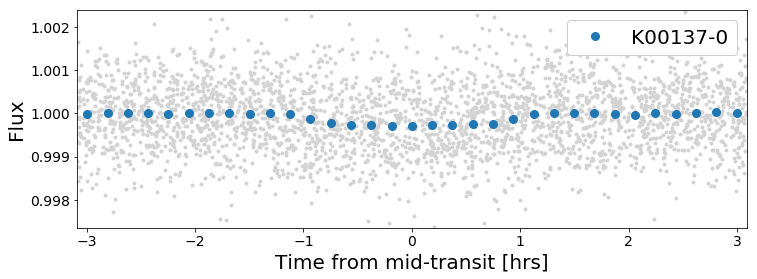

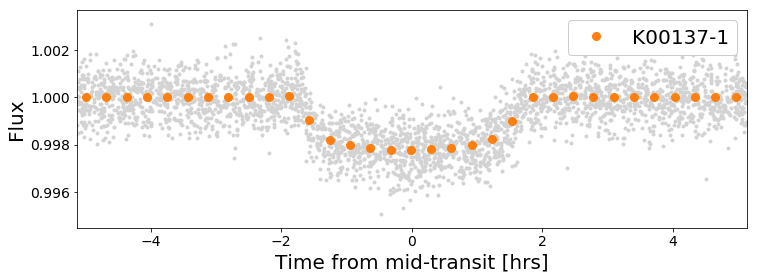

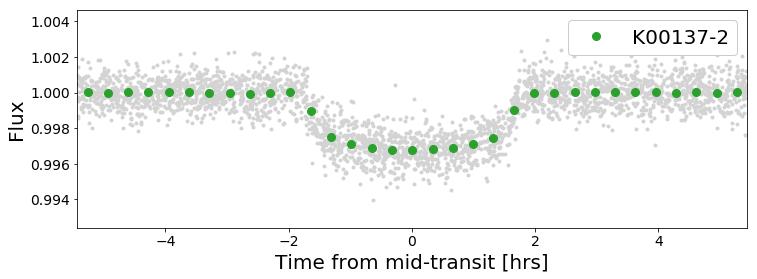

In [80]:
for npl, p in enumerate(planets):
    tts = p.tts[p.quality*~p.overlap]
    
    if len(tts) == 0:
        print("No non-overlapping high quality transits found for planet {0} (P = {1} d)".format(npl, p.period))
    
    else:
        t_folded = []
        f_folded = []

        # grab the data
        for t0 in tts:
            if sc is not None:
                use = np.abs(sc.time-t0)/p.duration < 1.5
                
                if np.sum(use) > 0:
                    t_folded.append(sc.time[use]-t0)
                    f_folded.append(sc.flux[use])
                    
            if lc is not None:
                use = np.abs(lc.time-t0)/p.duration < 1.5
                
                if np.sum(use) > 0:
                    t_folded.append(lc.time[use]-t0)
                    f_folded.append(lc.flux[use])
        
        # sort the data
        t_folded = np.hstack(t_folded)
        f_folded = np.hstack(f_folded)

        order = np.argsort(t_folded)
        t_folded = t_folded[order]
        f_folded = f_folded[order]
        
        # bin the data
        t_binned, f_binned = bin_data(t_folded, f_folded, p.duration/11)
        
        # set undersampling factor and plotting limits
        inds = np.arange(len(t_folded), dtype="int")
        inds = np.random.choice(inds, size=np.min([3000,len(inds)]), replace=False)
        
        ymin = 1 - 3*np.std(f_folded) - p.depth
        ymax = 1 + 3*np.std(f_folded)
        
        # plot the data
        plt.figure(figsize=(12,4))
        plt.plot(t_folded[inds]*24, f_folded[inds], ".", c="lightgrey")
        plt.plot(t_binned*24, f_binned, "o", ms=8, color="C{0}".format(npl), label="{0}-{1}".format(TARGET, npl))
        plt.xlim(t_folded.min()*24, t_folded.max()*24)
        plt.ylim(ymin, ymax)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Time from mid-transit [hrs]", fontsize=20)
        plt.ylabel("Flux", fontsize=20)
        plt.savefig(FIGURE_DIR + TARGET + '_{0:02d}_folded_transit_.png'.format(npl), bbox_inches='tight')
        plt.legend(fontsize=20, loc="upper right", framealpha=1)
        plt.show()

# Generate and model empirical autocorrelation function (ACF)

In [81]:
# generating figures inside imported modules creates issues with UChicago Midway RCC cluster
# it's easier to just define the function here in the main script

def plot_acf(xcor, acf_emp, acf_mod, xf, yf, freqs, target_name, season):
    """
    Docstring
    """
    fig = plt.figure(figsize=(20,5))

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.8)

    ax = plt.subplot2grid(shape=(5,10), loc=(0,0), rowspan=3, colspan=7)
    ax.plot(xcor*24, acf_emp, color='lightgrey')
    ax.plot(xcor*24, acf_mod, c='red')
    ax.set_xlim(xcor.min()*24,xcor.max()*24)
    ax.set_xticks(np.arange(0,xcor.max()*24,2))
    ax.set_xticklabels([])
    ax.set_ylim(acf_emp.min()*1.1, acf_emp.max()*1.1)
    ax.set_ylabel('ACF', fontsize=20)
    ax.text(xcor.max()*24-0.15, acf_emp.max(), '%s, SEASON %d' %(target_name, season), va='top', ha='right', fontsize=20)


    ax = plt.subplot2grid(shape=(5,10), loc=(0,7), rowspan=5, colspan=3)
    ax.plot(xf/24/3600*1e3, yf, color='k', lw=0.5)
    for f in freqs:
        ax.axvline(f/24/3600*1e3, color='red', zorder=0, lw=3, alpha=0.3) 
    ax.set_xlim(xf.min()/24/3600*1e3, xf.max()/24/3600*1e3)
    ax.set_ylim(yf.min(),1.2*yf.max())
    ax.set_ylabel('Power', fontsize=20)
    ax.set_yticks([])
    ax.set_xlabel('Frequency [mHz]', fontsize=20)

    for i, sf in enumerate(np.sort(freqs)[::-1]):
        ax.text(xf.min()/24/3600*1e3+0.1, yf.max()*(1.1-0.1*i), '%.2f min' %(24*60/sf), fontsize=16)


    ax = plt.subplot2grid(shape=(5,10), loc=(3,0), rowspan=2, colspan=7)
    ax.plot(xcor*24, acf_emp-acf_mod, c='lightgrey')
    ax.set_xlim(xcor.min()*24,xcor.max()*24)
    ax.set_xticks(np.arange(0,xcor.max()*24,2))
    ax.set_xlabel('Lag time [hours]', fontsize=20)
    ax.set_ylabel('Residuals', fontsize=20)    
    
    return fig

In [82]:
# determine what data type each season has
season_dtype = []

if sc is not None:
    sc_seasons = np.unique(sc.season)
else:
    sc_seasons = np.array([])

if lc is not None:
    lc_seasons = np.unique(lc.season)
else:
    lc_seasons = np.array([])

for z in range(4):
    if np.isin(z, sc_seasons):
        season_dtype.append("short")
    elif np.isin(z, lc_seasons):
        season_dtype.append("long")
    else:
        season_dtype.append("none")

Generating autocorrelation function
Season data types: ['short', 'short', 'short', 'short'] 



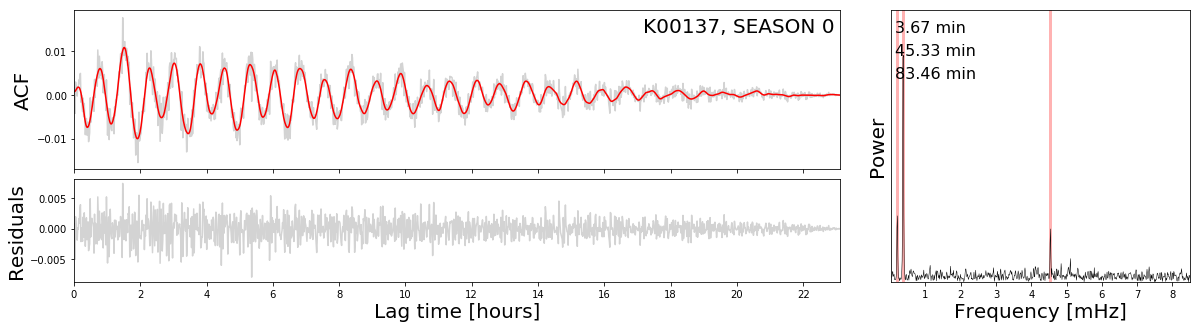

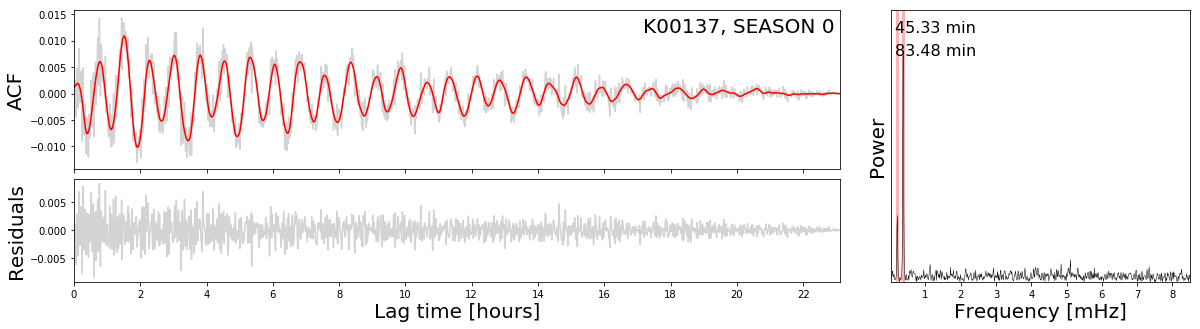

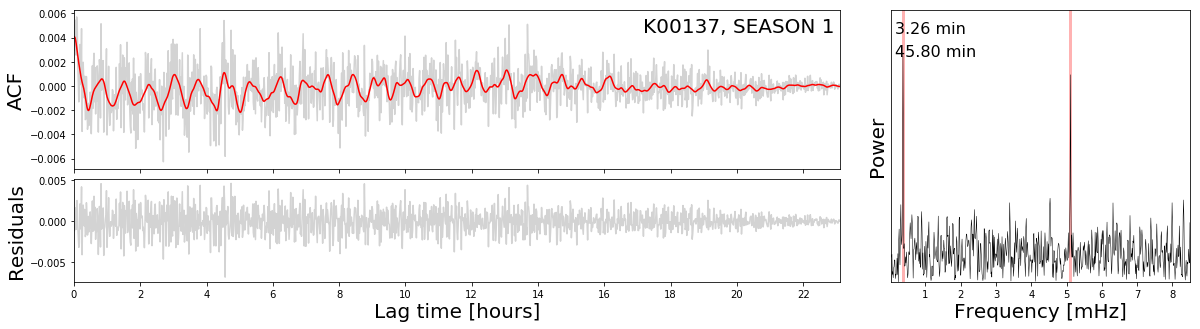

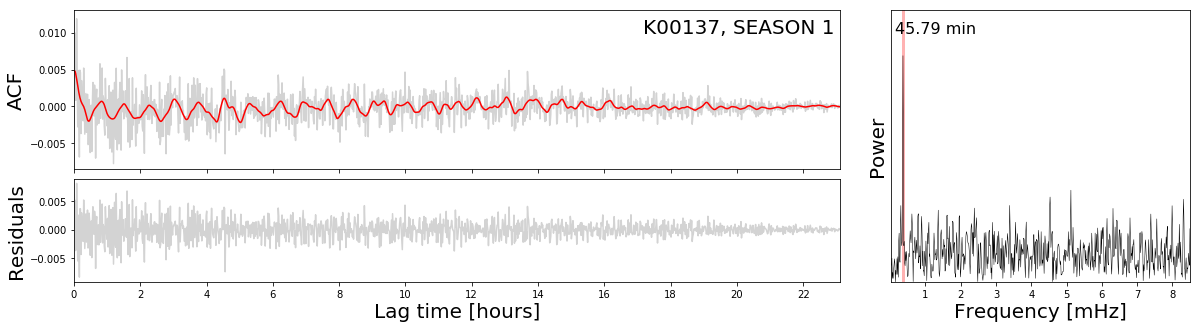

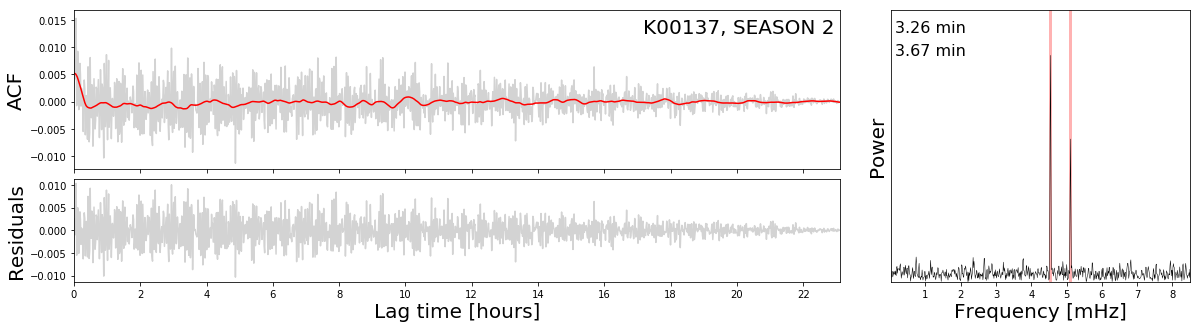

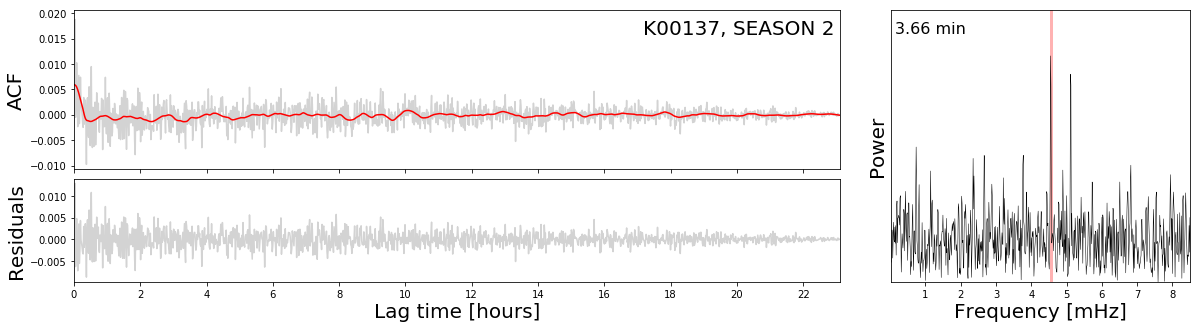

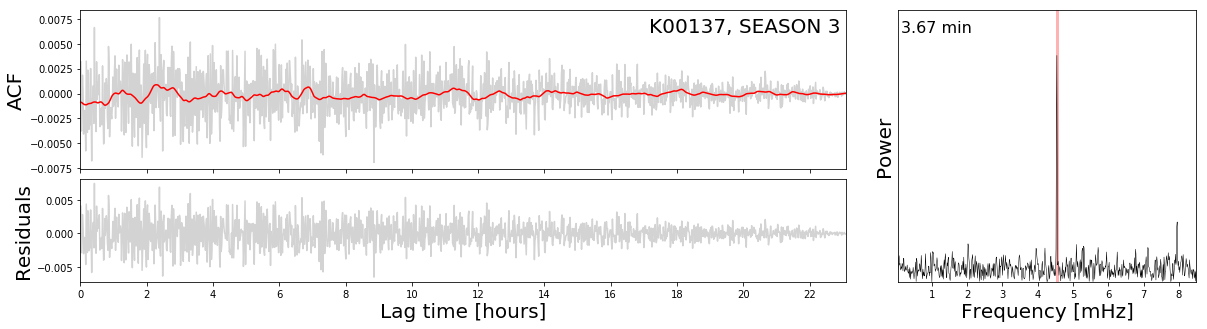

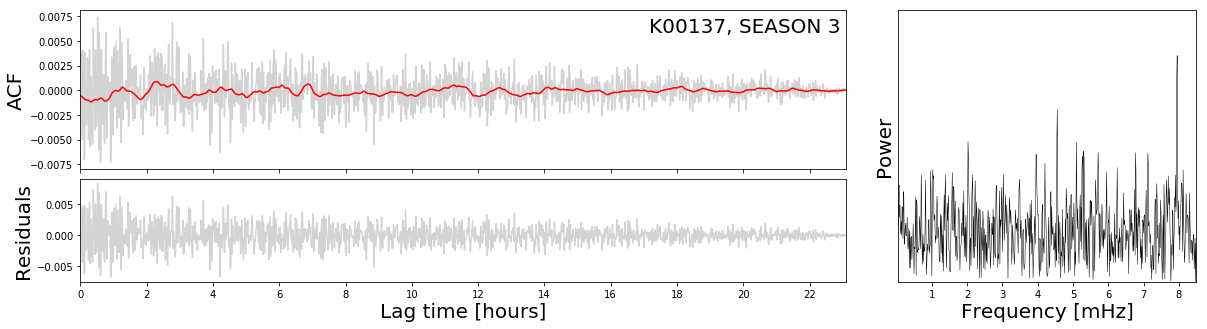

In [85]:
print("Generating autocorrelation function")
print("Season data types:", season_dtype, "\n")

# grab transit durations
durations = np.zeros(NPL)
for npl, p in enumerate(planets):
    durations[npl] = p.duration

    
# set cutoff between low and high frequency signals
fcut = 2/lcit
fmin = 2/(5*durations.max())


# now estimate the ACF
acf_lag = []
acf_emp = []
acf_mod = []
acf_freqs = []


for z in range(4):
    if season_dtype[z] == "none":
        acf_lag.append(None)
        acf_emp.append(None)
        acf_mod.append(None)
        acf_freqs.append(None)
        
        
    else:
        if season_dtype[z] == "short":
            Npts = int(np.min([5*(1/24+durations.max()),2/3*periods.min()])/scit)
            use = sc.season == z
            m_ = sc.mask[use]

            if np.sum(use) > 0:
                t_ = sc.time[use][~m_]
                f_ = sc.flux[use][~m_]
                c_ = sc.cadno[use][~m_]
                
        if season_dtype[z] == "long":
            Npts = int(np.min([5*(1/24+durations.max()),2/3*periods.min()])/lcit)
            use = lc.season == z
            m_ = lc.mask[use]

            if np.sum(use) > 0:
                t_ = lc.time[use][~m_]
                f_ = lc.flux[use][~m_]
                c_ = lc.cadno[use][~m_]

                
        if np.sum(use) > 0:
            # generate the empirical acf (if generate_acf fails, use very low amplitude white noise)
            try:
                xcor, acor = noise.generate_acf(t_, f_, c_, Npts)
            except:
                try:
                    Npts = int(2/3*Npts)
                    xcor, acor = noise.generate_acf(t_, f_, c_, Npts)
                except:
                    xcor = 1 + np.arange(Npts, dtype="float")
                    acor = np.random.normal(size=len(xcor))*np.std(f_)*np.finfo(float).eps
            
            if season_dtype[z] == "long":
                xcor = xcor*lcit
                method = "smooth"
                window_length = 3
            
            if season_dtype[z] == "short":
                xcor = xcor*scit
                method = "savgol"
                window_length = None
                

            # model the acf
            acor_emp, acor_mod, xf, yf, freqs = noise.model_acf(xcor, acor, fcut, fmin=fmin, 
                                                                method=method, window_length=window_length)

            # make some plots
            fig = plot_acf(xcor, acor_emp, acor_mod, xf, yf, freqs, TARGET, z)
            fig.savefig(FIGURE_DIR + TARGET + "_ACF_season_{0}.png".format(z), bbox_inches="tight")
           
            
            # filter out high-frequency components in short cadence data
            if season_dtype[z] == "short":
                fring = list(freqs[freqs > fcut])
                bw = 1/(lcit-scit) - 1/(lcit+scit)
                
                if len(fring) > 0:
                    # apply the notch filter
                    flux_filtered = detrend.filter_ringing(sc, break_tolerance, fring, bw)
                    

                    # search for addtional ringing frequencies
                    try:
                        xcor, acor = noise.generate_acf(t_, flux_filtered[use][~m_], c_, Npts)
                        xcor = xcor*scit
                    except:
                        pass
                    
                                        
                    new_freqs = noise.model_acf(xcor, acor, fcut, fmin=fmin, method="savgol")[4]
                    new_fring = new_freqs[new_freqs > fcut]
                    
                    for nf in new_fring:
                        if np.sum(np.abs(fring-nf) < bw) == 0:
                            fring.append(nf)
                    
                    # re-apply the notch filter with the new list of ringing frequencies
                    flux_filtered = detrend.filter_ringing(sc, break_tolerance, fring, bw)
                    
                    
                    # update the LiteCurve
                    sc.flux[use] = flux_filtered[use]
                    f_ = sc.flux[use][~m_]

                
                # re-run the ACF modeling on the filtered lightcurve
                try:
                    xcor, acor = noise.generate_acf(t_, f_, c_, Npts)
                    xcor = xcor*scit 
                except:
                    pass
                
                
                acor_emp, acor_mod, xf, yf, freqs = noise.model_acf(xcor, acor, fcut, fmin=fmin, method="savgol")

                fig = plot_acf(xcor, acor_emp, acor_mod, xf, yf, freqs, TARGET, z)
                fig.savefig(FIGURE_DIR + TARGET + "_ACF_season_{0}_filtered.png".format(z), bbox_inches="tight")
                
            
            # add to list
            acf_lag.append(xcor)
            acf_emp.append(acor_emp)
            acf_mod.append(acor_mod)
            acf_freqs.append(freqs)
            
        
        else:
            acf_lag.append(None)
            acf_emp.append(None)
            acf_mod.append(None)
            acf_freqs.append(None)   

# Generate and model synthetic noise

Generating synthetic noise

SEASON
short


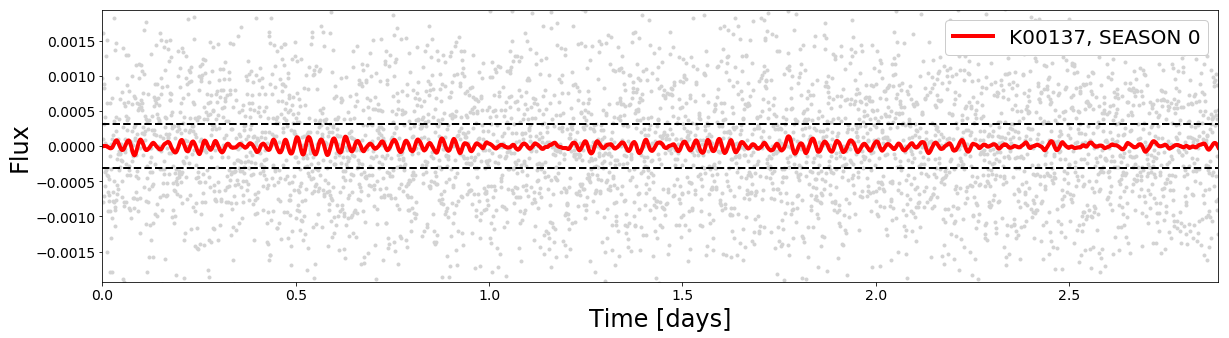

SEASON
short


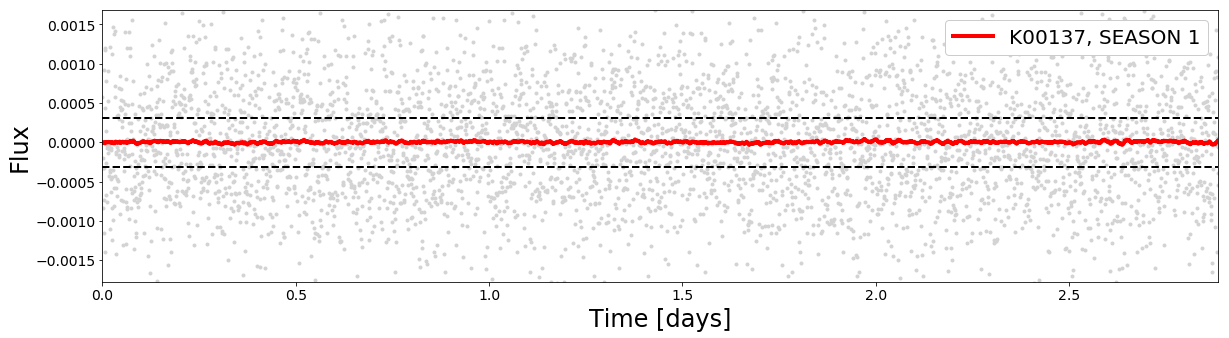

SEASON
short


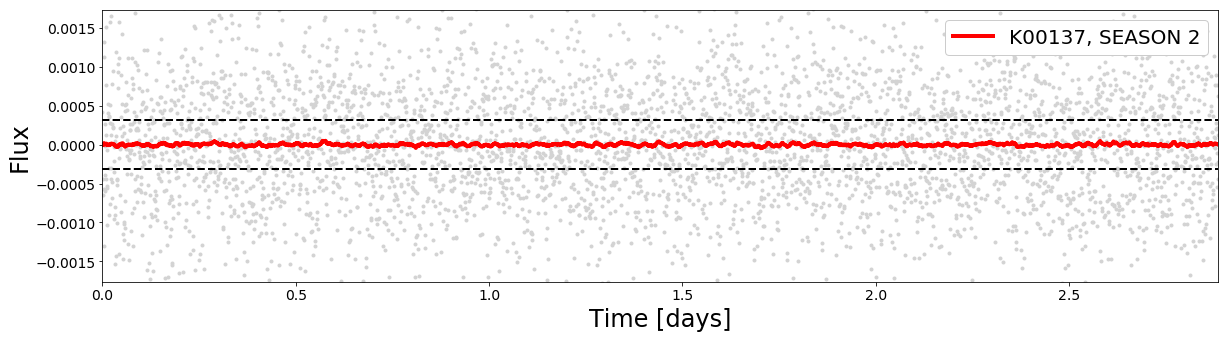

SEASON
short


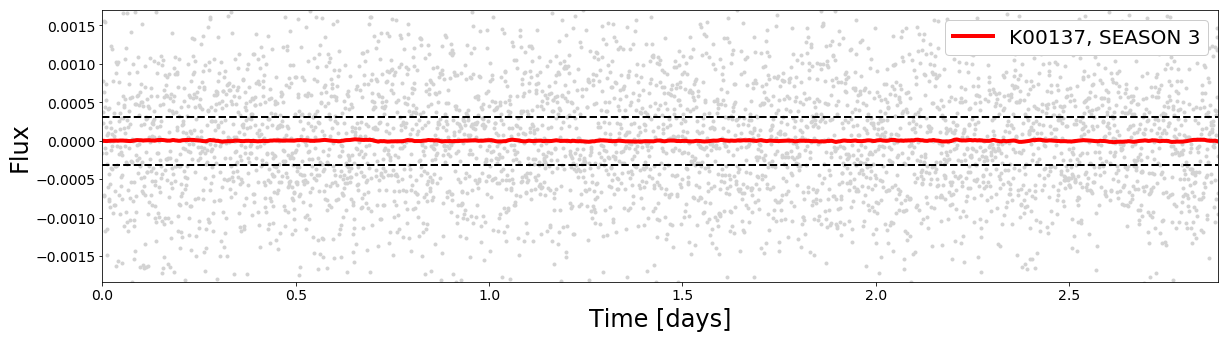

In [141]:
print("Generating synthetic noise\n")

synth_time  = []
synth_red   = []
synth_white = []


for z in range(4):
    print("SEASON")
    print(season_dtype[z])
    
    if season_dtype[z] == "none":
        synth_time.append(None)
        synth_red.append(None)
        synth_white.append(None)
       
        
    else:
        if season_dtype[z] == "short":
            Npts = int(2*durations.max()/scit)
            use = sc.season == z
            m_ = sc.mask[use]

            if np.sum(use) > 0:
                t_ = sc.time[use][~m_]
                f_ = sc.flux[use][~m_]
                
        
        if season_dtype[z] == "long":
            Npts = int(5*durations.max()/lcit)
            use = lc.season == z
            m_ = lc.mask[use]

            if np.sum(use) > 0:
                t_ = lc.time[use][~m_]
                f_ = lc.flux[use][~m_]
                
                
        if np.sum(use) > 0:
            if season_dtype[z] == "long":
                vector_length = 7*len(acf_lag[z])
            if season_dtype[z] == "short":
                vector_length = 3*len(acf_lag[z])
            
            
            # pull and split high/low frequencies
            freqs = np.copy(acf_freqs[z])

            low_freqs  = freqs[freqs <= fcut]
            high_freqs = freqs[freqs > fcut]


            # generate some synthetic correlated noise
            clipped_acf = (acf_mod[z][:Npts])*np.linspace(1,0,Npts)

            x, red_noise, white_noise = noise.generate_synthetic_noise(acf_lag[z][:Npts], clipped_acf, 
                                                                       vector_length, np.std(f_))

            # add to list
            synth_time.append(x)
            synth_red.append(red_noise)
            synth_white.append(white_noise)


            # plot the noise
            plt.figure(figsize=(20,5))
            plt.plot(x, white_noise + red_noise, ".", c="lightgrey")
            plt.plot(x, red_noise, c="r", lw=4, label="{0}, SEASON {1}".format(TARGET, z))
            plt.axhline(depths.max(), c="k", ls=":", lw=2)
            plt.axhline(depths.min(), c="k", ls="--", lw=2)
            plt.axhline(-depths.min(), c="k", ls="--", lw=2)
            plt.axhline(-depths.max(), c="k", ls=":", lw=2)
            plt.xlim(x.min(),x.max())
            plt.ylim(np.percentile(white_noise,1), np.percentile(white_noise,99))
            plt.xlabel("Time [days]", fontsize=24)
            plt.ylabel("Flux", fontsize=24)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.legend(fontsize=20, loc="upper right", framealpha=1)
            plt.savefig(FIGURE_DIR + TARGET + "_synthetic_noise_season_{0}.png".format(z), bbox_inches="tight")
            plt.show()

            
        else:
            synth_time.append(None)
            synth_red.append(None)
            synth_white.append(None)

Fitting a GP to synthetic noise



optimizing logp for variables: [logw0]


message: Optimization terminated successfully.
logp: 24937.054437895178 -> 37095.9798164398
optimizing logp for variables: [logQ_off]


message: Optimization terminated successfully.
logp: 37095.9798164398 -> 37814.94251207115
optimizing logp for variables: [logSw4]


message: Optimization terminated successfully.
logp: 37814.94251207115 -> 37819.69875649328
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 37819.69875649328 -> 37819.70147746362
optimizing logp for variables: [logjit]


message: Optimization terminated successfully.
logp: 37819.70147746362 -> 44586.40540936106
optimizing logp for variables: [logjit, mean, logSw4, logQ_off, logw0]


message: Desired error not necessarily achieved due to precision loss.
logp: 44586.40540936106 -> 44653.072793835694
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, mean, logSw4, logQ_off, logw0]


Sampling 2 chains for 6_000 tune and 1_500 draw iterations (12_000 + 3_000 draws total) took 188 seconds.


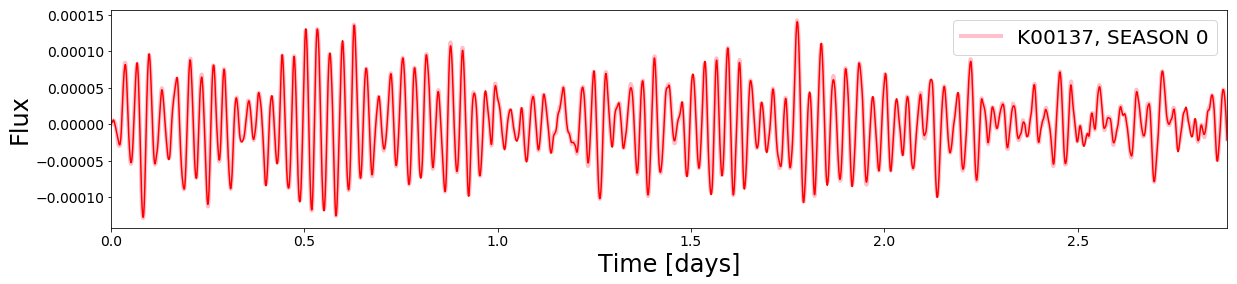

optimizing logp for variables: [logw0]


message: Optimization terminated successfully.
logp: 31440.65401832456 -> 43186.498015850346
optimizing logp for variables: [logQ_off]


message: Optimization terminated successfully.
logp: 43186.498015850346 -> 43404.32140496526
optimizing logp for variables: [logSw4]


message: Desired error not necessarily achieved due to precision loss.
logp: 43404.32140496526 -> 43467.88597268845
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 43467.88597268845 -> 43467.89087053584
optimizing logp for variables: [logjit]


message: Optimization terminated successfully.
logp: 43467.89087053584 -> 45517.8375356583
optimizing logp for variables: [logjit, mean, logSw4, logQ_off, logw0]


message: Desired error not necessarily achieved due to precision loss.
logp: 45517.8375356583 -> 46559.98472059848
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, mean, logSw4, logQ_off, logw0]


Sampling 2 chains for 6_000 tune and 1_500 draw iterations (12_000 + 3_000 draws total) took 202 seconds.


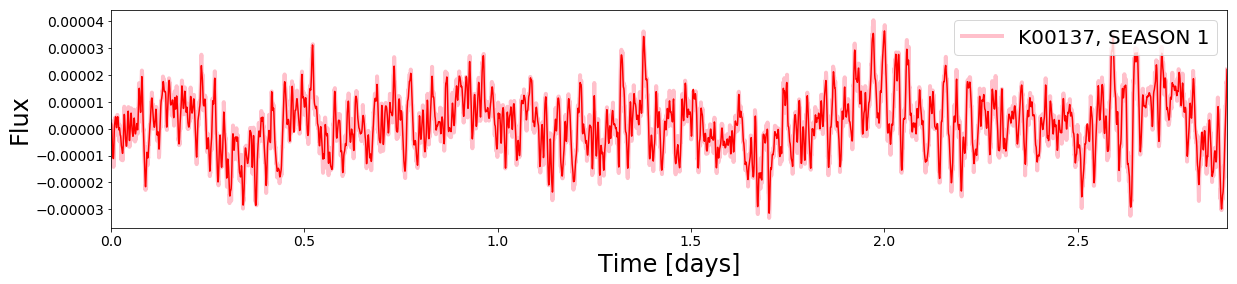

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: there are remaining high-frequency noise components
optimizing logp for variables: [logw0]


message: Desired error not necessarily achieved due to precision loss.
logp: 42359.81520869226 -> 42443.13692899172
optimizing logp for variables: [logQ_off]


message: Optimization terminated successfully.
logp: 42443.13692899172 -> 42476.770984950555
optimizing logp for variables: [logSw4]


message: Optimization terminated successfully.
logp: 42476.770984950555 -> 42502.65351848591
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 42502.65351848591 -> 42502.653658794196
optimizing logp for variables: [logjit]


message: Optimization terminated successfully.
logp: 42502.653658794196 -> 45034.905275468926
optimizing logp for variables: [logjit, mean, logSw4, logQ_off, logw0]


message: Desired error not necessarily achieved due to precision loss.
logp: 45034.905275468926 -> 45785.550702029
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, mean, logSw4, logQ_off, logw0]


Sampling 2 chains for 6_000 tune and 1_500 draw iterations (12_000 + 3_000 draws total) took 314 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


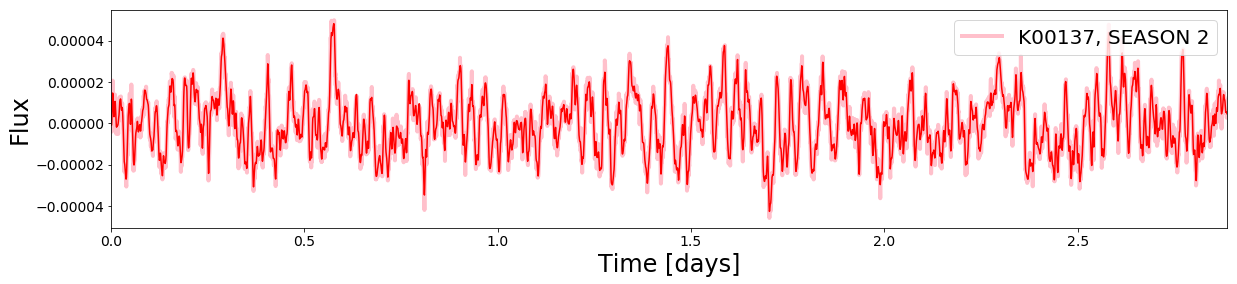

optimizing logp for variables: [logw0]


message: Optimization terminated successfully.
logp: 46283.19233389941 -> 46347.35045171657
optimizing logp for variables: [logQ_off]


message: Optimization terminated successfully.
logp: 46347.35045171657 -> 46347.75050447669
optimizing logp for variables: [logSw4]


message: Optimization terminated successfully.
logp: 46347.75050447669 -> 46348.295587686924
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 46348.295587686924 -> 46348.29724588278
optimizing logp for variables: [logjit]


message: Optimization terminated successfully.
logp: 46348.29724588278 -> 52119.40074043559
optimizing logp for variables: [logjit, mean, logSw4, logQ_off, logw0]


message: Desired error not necessarily achieved due to precision loss.
logp: 52119.40074043559 -> 52395.883513976034
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logjit, mean, logSw4, logQ_off, logw0]


Sampling 2 chains for 6_000 tune and 1_500 draw iterations (12_000 + 3_000 draws total) took 346 seconds.
The acceptance probability does not match the target. It is 0.9603536160448336, but should be close to 0.9. Try to increase the number of tuning steps.


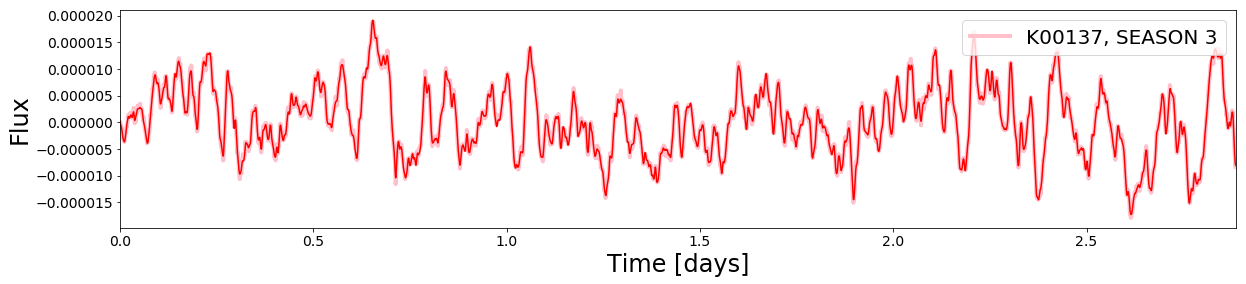

In [142]:
print("Fitting a GP to synthetic noise\n")

gp_priors = []


for z in range(4):
    if season_dtype[z] == "none":
        gp_priors.append(None)
       
    else:
        srz = synth_red[z]
        
        # pull and split high/low frequencies
        freqs = np.copy(acf_freqs[z])
        
        if freqs is not None:

            low_freqs  = freqs[freqs <= fcut]
            high_freqs = freqs[freqs > fcut]

            if len(low_freqs) > 0:
                lf = low_freqs[0]
            else:
                lf = None
                
            if len(high_freqs) > 0:
                warnings.warn("there are remaining high-frequency noise components")
                
        else:
            lf = None


        # fit a GP model to the synthetic noise
        try:            
            gp_model = noise.build_sho_model(synth_time[z], 
                                             srz + np.random.normal(srz)*np.std(srz)*0.1, 
                                             var_method = "fit", 
                                             fmax = 2/lcit, 
                                             f0 = lf)
        
            with gp_model:
                gp_map = gp_model.test_point

                for mv in gp_model.vars:
                    gp_map = pmx.optimize(start=gp_map, vars=[mv])

                gp_map = pmx.optimize(start=gp_map)
                
                try:
                    gp_trace = pmx.sample(tune=6000, draws=1500, start=gp_map, chains=2, target_accept=0.9)
                except:
                    gp_trace = pmx.sample(tune=12000, draws=1500, start=gp_map, chains=2, target_accept=0.95)
                
                
        except:
            gp_model = noise.build_sho_model(synth_time[z], 
                                             srz + np.random.normal(srz)*np.std(srz)*0.1,
                                             var_method = "local",
                                             fmax = 2/lcit,
                                             f0 = lf, 
                                             Q0 = 1/np.sqrt(2))
        
            with gp_model:
                gp_map = gp_model.test_point

                for mv in gp_model.vars:
                    gp_map = pmx.optimize(start=gp_map, vars=[mv])

                gp_map = pmx.optimize(start=gp_map)
                
                try:
                    gp_trace = pmx.sample(tune=12000, draws=1500, start=gp_map, chains=2, target_accept=0.95)
                except:
                    gp_trace = gp_map
            
        
        # save the priors
        gp_priors.append(noise.make_gp_prior_dict(gp_trace))

        plt.figure(figsize=(20,4))
        plt.plot(synth_time[z], synth_red[z], c="pink", lw=4, label="{0}, SEASON {1}".format(TARGET, z))
        plt.plot(synth_time[z], np.nanmedian(gp_trace["pred"], axis=0), c="red")
        plt.xlim(synth_time[z].min(), synth_time[z].max())
        plt.xlabel("Time [days]", fontsize=24)
        plt.ylabel("Flux", fontsize=24)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(loc="upper right", fontsize=20)
        plt.savefig(FIGURE_DIR + TARGET + "_GP_noise_model_{0}.png".format(z), bbox_inches="tight")
        plt.show()

In [143]:
# list of all quarters with data
quarters = []

if lc is not None:
    quarters = np.hstack([quarters, np.unique(lc.quarter)])
if sc is not None:
    quarters = np.hstack([quarters, np.unique(sc.quarter)])

quarters = np.array(np.sort(quarters), dtype="int")

# get variance of each quarter
var_by_quarter = []

for i, q in enumerate(quarters):
    if (sc is not None) and (np.sum(sc.quarter==q) > 0):
        var_by_quarter.append(np.var(sc.flux[sc.mask*(sc.quarter==q)]))
    elif (lc is not None) and (np.sum(lc.quarter==q) > 0):
        var_by_quarter.append(np.var(lc.flux[lc.mask*lc.quarter==q]))
    else:
        var_by_quarter.append(None)

# Save detrended lightcurves and estimates of the noise properties

In [144]:
# Save detrended lightcurves as .fits files
try:
    lc.to_fits(TARGET, DLC_DIR + TARGET + "_lc_detrended.fits")
except:
    print("No long cadence data")

try:
    sc.to_fits(TARGET, DLC_DIR + TARGET + "_sc_detrended.fits")
except:
    print("No short cadence data")

In [145]:
# Save var_by_quarter
data_out  = np.vstack([quarters, var_by_quarter]).swapaxes(0,1)
fname_out = NOISE_DIR + TARGET + "_var_by_quarter.txt"
    
np.savetxt(fname_out, data_out, fmt=("%1d', '%.15f"), delimiter="\t")


# save gp_priors
for z in range(4):
    try:
        for k in gp_priors[z].keys():
            gp_priors[z][k] = list(gp_priors[z][k])

        fname_out = NOISE_DIR + TARGET + "_shoterm_gp_priors_{0}.txt".format(z)

        with open(fname_out, 'w') as file:
            json.dump(gp_priors[z], file)
            
    except:
        pass

In [ ]:
print("TOTAL RUNTIME = %.2f min" %((timer()-global_start_time)/60))